Sphere synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/spheref.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 22.3 MB/s 
     |████████████████████████████████| 872 kB 43.2 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19878 sha256=41085c6a46cc4e20dd035cc036de3ff387ee4ae5eb623203a8bbe349af5ae316
  Stored in directory: /root/.cache/pip/wheels/77/da/06/166ba012a0d819a121e3f58372c668c804511875d04e16f383
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=b6e360b4a3b771daed26b3b1e3aaf1f10525ed74351e6eefe49595616d21c19a
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Sphere'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Sphere':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -5.12 
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * ( x1_training ** 2
                            + x2_training ** 2
                            )
  

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP dEI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 1.5925778782479172
2  	 [5.12 5.12]	 52.4288	 1.275455677703416	 1.5925778776207775
3  	 [-5.12  5.12]	 52.4288	 1.275455677703416	 1.5925740218285798
4  	 [3.42250321 0.51119867]	 11.974852281651728	 1.275455677703416	 1.5922785146675416
5  	 [ 0.4376922  -2.49216761]	 6.40247388006668	 1.275455677703416	 1.5826945371458223
6  	 [0.9351802 5.12     ]	 27.08896201094414	 1.275455677703416	 1.582392487992473
7  	 [-5.12        1.48759709]	 28.427345114817157	 1

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 1.1945155933603315
2  	 [ 4.81417587 -3.13615063]	 33.01173008164121	 0.6972563370202991	 1.19451434962462
3  	 [-0.00653243  5.12      ]	 26.214442672594636	 0.6972563370202991	 1.1944864861929108
4  	 [-5.12  5.12]	 52.4288	 0.6972563370202991	 1.194309676187235
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 1.193528218493978
6  	 [2.56833586 0.07051569]	 6.6013215541945405	 0.6972563370202991	 1.1664651819935616
7  	 [-5.12      -1.2127095]	 27.6850643

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    
1  	 [ 4.62594968 -1.72716685]	 24.382515760418432	 4.59675431006429	 4.604111320765137
2  	 [-4.57811421  5.09191652]	 46.88674355303911	 4.59675431006429	 4.604110931072832
3  	 [ 0.82883316 -5.12      ]	 26.90136441051294	 4.59675431006429	 4.604061110846
4  	 [-0.44145971  5.12      ]	 26.409286677630373	 4.59675431006429	 4.582033649432143
5	 [ 0.82827233 -1.27984998]	 2.3240510288035345	 2.3240510288035345	 4.571526508121183
6  	 [ 5.12 -5.12]	 52.4288	 2.3240510288035345	 2.4141974840619382
7  	 [2.8116592  0.86098859]	 8.64672877789

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    
1  	 [-5.12        4.14099457]	 43.36223602290998	 6.844040613967918	 6.844198530978562
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 6.844193745735943
3  	 [0.31011482 5.12      ]	 26.310571200528994	 6.844040613967918	 6.8441879641995556
4  	 [-0.95718136 -5.12      ]	 27.1305961538866	 6.844040613967918	 6.833287557187282
5	 [0.70230377 1.02858908]	 1.5512260872011265	 1.5512260872011265	 6.832515171849922
6  	 [-5.12        0.39264056]	 26.36856660547305	 1.5512260872011265	 1.7344789469539317
7  	 [-1.7880775   2.34208306]	 8.682

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 1.6281597426122008
2  	 [5.12       5.01238555]	 51.33840892332317	 1.3234068721819314	 1.6281590084630853
3  	 [-5.12       -0.04786458]	 26.216691018425248	 1.3234068721819314	 1.6274860861078573
4  	 [0.96524419 5.12      ]	 27.14609634009872	 1.3234068721819314	 1.6210814251494714
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 1.6197024023886009
6  	 [ 0.60985122 -5.12      ]	 26.586318508253523	 1.3234068721819314	 1.5889836570340783
7  	 [ 5.12   

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    
1  	 [4.11965622 5.12      ]	 43.18596737725548	 0.7844720799352826	 1.2507225569805602
2  	 [-5.12 -5.12]	 52.4288	 0.7844720799352826	 1.250722531315433
3  	 [-5.12  5.12]	 52.4288	 0.7844720799352826	 1.2501641658874603
4  	 [-0.44948625  5.12      ]	 26.416437893103673	 0.7844720799352826	 1.24965964240629
5  	 [-0.92587221 -4.00794354]	 16.92085080283722	 0.7844720799352826	 1.247417583134826
6  	 [1.96993755 1.6541008 ]	 6.616703427642042	 0.7844720799352826	 1.2394745047622315
7  	 [5.12       1.54731213]	 28.60857482

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 5.623970530540822
2  	 [ 5.12 -5.12]	 52.4288	 5.622519010932044	 5.623965991173253
3  	 [3.32677936 5.12      ]	 37.28186092483975	 5.622519010932044	 5.623914822676422
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 5.6239846283798745
5	 [ 1.22341687 -0.77267839]	 2.0937807397208346	 2.0937807397208346	 5.60266915498386
6  	 [-1.25614646  5.12      ]	 27.792303930767755	 2.0937807397208346	 2.2023884708328776
7  	 [ 2.86592422 -2.42725294]	 14.105078480

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    
1  	 [-4.36608793e-04  2.06674367e+00]	 4.271429598672614	 0.10287109474532606	 0.8513709009566058
2  	 [-5.12  5.12]	 52.4288	 0.10287109474532606	 0.8503753017804847
3  	 [ 4.04653495 -5.12      ]	 42.5888451205719	 0.10287109474532606	 0.8503739366088535
4  	 [-5.12       -0.23607549]	 26.270131638470147	 0.10287109474532606	 0.8503427325439412
5  	 [-0.8721827  5.12     ]	 26.975102668941314	 0.10287109474532606	 0.8413999811990419
6  	 [ 0.78586964 -3.21535839]	 10.956120685663624	 0.10287109474532606	 0.827561448876

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    
1  	 [3.69491889 4.82146316]	 36.89893267190826	 7.349882113053805	 7.349939623433926
2  	 [-2.28325892  5.12      ]	 31.42767130669173	 7.349882113053805	 7.34993868320942
3  	 [ 4.85377973 -0.96421613]	 24.488890382834978	 7.349882113053805	 7.34993821075366
4	 [0.53602364 1.34185879]	 2.0879063532673254	 2.0879063532673254	 7.3488930525708644
5  	 [ 4.2514357 -5.12     ]	 44.28910548315764	 2.0879063532673254	 2.2392883048791363
6  	 [-5.12        3.44023444]	 38.049613014731825	 2.0879063532673254	 2.15458256401783
7  	 [-1.8

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    
1  	 [ 5.12       -0.36517683]	 26.347754113641418	 7.941821858928501	 7.941751005927989
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 7.941699776534956
3  	 [-5.12       -0.59618645]	 26.569838285867093	 7.941821858928501	 7.931984859740016
4  	 [-0.58314795  5.12      ]	 26.554461526600576	 7.941821858928501	 7.901342605036744
5  	 [-5.12  5.12]	 52.4288	 7.941821858928501	 7.888766806012915
6	 [-0.91598268  0.09808346]	 0.8486446347143605	 0.8486446347143605	 7.859195386901564
7  	 [ 1.72078319 -0.47271319]	 3.184552541926712	 0.84

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 1.1898686681311723
2  	 [-5.12  5.12]	 52.4288	 0.6899456214148796	 1.189860132757955
3  	 [ 5.12       -0.71940695]	 26.731946353325895	 0.6899456214148796	 1.1881163372713106
4  	 [0.92473097 5.12      ]	 27.06952737499057	 0.6899456214148796	 1.17087177720776
5  	 [-0.19961111 -2.46512035]	 6.1166629526971885	 0.6899456214148796	 1.1679657232702403
6  	 [1.75668299 0.19079158]	 3.1223365719044116	 0.6899456214148796	 1.13857510135968
7  	 [-2.93752431  2.

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    
1  	 [5.12 5.12]	 52.4288	 5.993464196233534	 5.994237365089377
2  	 [-4.15109266 -5.12      ]	 43.44597023451905	 5.993464196233534	 5.994237163434248
3	 [2.28117334 0.77905251]	 5.810674613708926	 5.810674613708926	 5.99412775693692
4  	 [0.22734929 5.12      ]	 26.266087701518654	 5.810674613708926	 5.811320510228786
5  	 [-0.05693962 -3.03366024]	 9.206336598212415	 5.810674613708926	 5.809714302958114
6  	 [-5.12       -1.31886451]	 27.953803608116285	 5.810674613708926	 5.781766804080118
7  	 [5.12       0.16037262]	 26.240119

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    
1  	 [-4.10876704 -2.60547476]	 23.670465283396044	 7.271500601275535	 7.271568186175726
2  	 [-5.12       2.9827349]	 35.111107491263496	 7.271500601275535	 7.271566998042995
3  	 [-0.59462664 -5.12      ]	 26.567980840484395	 7.271500601275535	 7.269457950858464
4  	 [-1.67014801  5.12      ]	 29.003794380347195	 7.271500601275535	 7.2612291789022745
5	 [-0.68837786 -0.62671511]	 0.8666359153539505	 0.8666359153539505	 7.25939757405582
6  	 [ 5.12 -5.12]	 52.4288	 0.8666359153539505	 1.2851812805574272
7  	 [-2.04987097  1.08287186]	 5

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    
1  	 [-5.12 -5.12]	 52.4288	 3.480496204392171	 3.513633268751706
2  	 [5.10055263 5.12      ]	 52.23003717223822	 3.480496204392171	 3.5136322123647155
3  	 [-5.12        0.39374029]	 26.369431412772123	 3.480496204392171	 3.513618757181146
4  	 [ 5.12       -0.07494469]	 26.220016706989426	 3.480496204392171	 3.513561437643989
5	 [-1.58751435  0.05051817]	 2.522753899086134	 2.522753899086134	 3.443790162056067
6  	 [-5.12  5.12]	 52.4288	 2.522753899086134	 2.5531384833655757
7  	 [-1.42886808 -5.12      ]	 28.256063986638797	 2.

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    
1  	 [2.7754098  2.98802689]	 16.631204280641075	 5.383887924980681	 5.38606446985145
2  	 [-5.12        4.81945146]	 49.44151236323329	 5.383887924980681	 5.38606287832432
3  	 [-0.72303187  5.12      ]	 26.737175089392025	 5.383887924980681	 5.382688333805508
4  	 [-0.11962742 -5.12      ]	 26.22871072080369	 5.383887924980681	 5.3791052722500705
5  	 [5.12       0.18688128]	 26.249324613482322	 5.383887924980681	 5.367120393066455
6	 [ 1.08677268 -0.33543745]	 1.2935931367517852	 1.2935931367517852	 5.3542625438225135
7  	 [5.1

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    
1  	 [2.23926683 5.12      ]	 31.228715941011302	 8.084978900492077	 8.084990713563913
2  	 [5.12       0.62055316]	 26.599486219627295	 8.084978900492077	 8.08496973437256
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 8.084598853373462
4	 [0.93966402 0.94350446]	 1.7731691309347872	 1.7731691309347872	 8.078810270013056
5  	 [ 5.12 -5.12]	 52.4288	 1.7731691309347872	 1.970311806386343
6  	 [-0.90068289  3.16225133]	 10.811063123823379	 1.7731691309347872	 1.9332775111788665
7  	 [-5.12       -1.45531059]	 28.33232890624392	 1.

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 2.6751832097646906
2  	 [-4.96030997  4.71854675]	 46.869358421617264	 2.5824114132885994	 2.675181104396316
3  	 [0.0054658 5.12     ]	 26.214429874925216	 2.5824114132885994	 2.6749388341604416
4  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 2.674214638086261
5  	 [ 0.85280561 -2.81524164]	 8.652862906314947	 2.5824114132885994	 2.671807769251688
6  	 [ 5.12       -0.72468489]	 26.739568194706226	 2.5824114132885994	 2.62484355031104
7  	 [-2.13106049  2.719

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 2.489407676741919
2  	 [-5.12       -1.45227108]	 28.3234912830853	 2.3742017032787373	 2.4869963987778716
3  	 [-1.15623557  1.83903844]	 4.7189430902825364	 2.3742017032787373	 2.4773965068655976
4  	 [-2.03883017  5.12      ]	 30.371228446245972	 2.3742017032787373	 2.4558521427956714
5  	 [-0.98972163 -1.46068201]	 3.1131408269185528	 2.3742017032787373	 2.450588479982373
6  	 [ 1.01444809 -5.12      ]	 27.24350492040793	 2.3742017032787373	 2.42916051852

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    
1  	 [ 4.75309484 -5.12      ]	 48.80631052939498	 12.957869519084127	 12.957869496486827
2	 [ 1.50914555 -1.41207467]	 4.271475151684537	 4.271475151684537	 12.955950197051237
3  	 [5.12 5.12]	 52.4288	 4.271475151684537	 4.2678972268952045
4  	 [-5.12       -1.05768757]	 27.33310300391219	 4.271475151684537	 4.266851226573325
5  	 [-1.25757868  5.12      ]	 27.79590413758324	 4.271475151684537	 4.263894782280833
6	 [-1.16801707  0.34111127]	 1.4806207833491367	 1.4806207833491367	 4.2558389582916645
7  	 [ 1.27352936 -5.12   

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    
1  	 [-3.56773338 -5.12      ]	 38.94312144661133	 1.579257056101869	 1.8240962518239396
2  	 [ 5.12 -5.12]	 52.4288	 1.579257056101869	 1.8226209041327182
3  	 [ 5.12       -0.75178149]	 26.77957540342997	 1.579257056101869	 1.8200109105974476
4  	 [-2.73894187  5.12      ]	 33.71620254132422	 1.579257056101869	 1.8095487771140286
5  	 [-5.12       -1.69354954]	 29.08251005768972	 1.579257056101869	 1.7990949415787494
6  	 [1.46989696 0.39167176]	 2.3140038482079777	 1.579257056101869	 1.778527899656212
7  	 [-1.46043624 -2.1875888 ]	

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 1.5925778782479172
2  	 [5.12       3.36783542]	 37.55671539878192	 1.275455677703416	 1.592577857354429
3  	 [ 2.40146578 -0.17378187]	 5.797238022053689	 1.275455677703416	 1.5899887414526428
4  	 [-5.12        4.36680096]	 45.28335059684448	 1.275455677703416	 1.592552727046903
5  	 [1.30762101 5.12      ]	 27.924272700727766	 1.275455677703416	 1.5870668275406425
6  	 [ 0.11350659 -5.12      ]	 26.227283746285483	 1.275455677703416	 1.5819783785734132
7  	

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    
1  	 [5.12 5.12]	 52.4288	 0.6972563370202991	 1.1945156055900972
2  	 [ 4.84260546 -3.96517156]	 39.173413151255836	 0.6972563370202991	 1.1945141517615334
3  	 [-0.14724304  5.12      ]	 26.236080513371153	 0.6972563370202991	 1.194472843498889
4  	 [4.19814932 0.55652488]	 17.934177627777412	 0.6972563370202991	 1.1937448998515563
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 1.1935282244680223
6  	 [-4.17926789  4.68338015]	 39.400329749918235	 0.6972563370202991	 1.1879518196845393
7  	 [0.7471435  1.53043763]	 2.9004

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    
1  	 [ 2.87036899 -1.98289163]	 12.170877343622498	 4.59675431006429	 4.604079794844259
2  	 [-3.33114862  5.05305125]	 36.62987805318713	 4.59675431006429	 4.6040867880204726
3  	 [-0.40701955 -2.40839967]	 5.966053860772153	 4.59675431006429	 4.53181634231452
4  	 [ 1.47776527 -5.12      ]	 28.398190192382167	 4.59675431006429	 4.574993886896152
5  	 [5.12       0.52669006]	 26.491802422845403	 4.59675431006429	 4.566278849381859
6  	 [ 5.12       -4.54672744]	 46.88713045033706	 4.59675431006429	 4.5706407016501505
7  	 [0.43977767 5.12 

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    
1  	 [-1.14334581  4.64643194]	 22.896569443900606	 6.844040613967918	 6.844198691403709
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 6.844193745732506
3  	 [-0.95819369 -5.12      ]	 27.132535153656406	 6.844040613967918	 6.833287493862271
4	 [0.65712638 1.17928828]	 1.8225359163068036	 1.8225359163068036	 6.831378150964439
5  	 [-5.12        2.45166061]	 32.22503973412286	 1.8225359163068036	 2.0182197598880456
6  	 [2.62683686 5.12      ]	 33.11467188409872	 1.8225359163068036	 1.9994874504192086
7  	 [-5.12       -1.41933157]	 28

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 1.6281597426122008
2  	 [5.12 5.12]	 52.4288	 1.3234068721819314	 1.6281595760134915
3  	 [-5.12       -0.27719042]	 26.29123452807068	 1.3234068721819314	 1.6272897908789583
4  	 [0.99551455 5.11914473]	 27.1966919681028	 1.3234068721819314	 1.620924980517749
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 1.6196491999775522
6  	 [ 1.26046851 -2.70481137]	 8.904785400598776	 1.3234068721819314	 1.5871514748759203
7  	 [ 5.12       -1.48084119]	 28.40729

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    
1  	 [5.12 5.12]	 52.4288	 0.7844720799352826	 1.250722557209966
2  	 [-3.74535283 -5.12      ]	 40.24206779776266	 0.7844720799352826	 1.2507225040704095
3  	 [0.08402923 5.12      ]	 26.221460911676587	 0.7844720799352826	 1.2505187585884068
4  	 [2.56669879 1.74876145]	 9.646109280504115	 0.7844720799352826	 1.241133012953653
5  	 [-0.25046164 -3.54643381]	 12.639923790732329	 0.7844720799352826	 1.2265198120808376
6  	 [-3.60506296  4.55551311]	 33.749178580091325	 0.7844720799352826	 1.233525344338636
7  	 [-2.88953851 

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 5.623970530540822
2  	 [3.33590081 5.12      ]	 37.342634208733344	 5.622519010932044	 5.623914820132658
3  	 [ 4.5235682  -4.16736717]	 37.82961837123037	 5.622519010932044	 5.623289213108925
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 5.6239846283798745
5	 [ 1.20807972 -0.75572559]	 2.0305777820257194	 2.0305777820257194	 5.602413738713855
6  	 [1.93980093 1.96894931]	 7.639589039087927	 2.0305777820257194	 2.0177240265815866
7  	 [-1.24967759  5.12

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    
1  	 [0.02041459 1.98577863]	 3.943733542072024	 0.10287109474532606	 0.8513248707571486
2  	 [-5.03492225  2.95509263]	 34.08301446412634	 0.10287109474532606	 0.8503734940757717
3  	 [-5.12       -1.47896116]	 28.40172612269111	 0.10287109474532606	 0.8488848361561557
4  	 [ 2.57855628 -4.69210849]	 28.66483461803054	 0.10287109474532606	 0.8503612250776876
5  	 [0.12155999 4.9809562 ]	 24.824701467598562	 0.10287109474532606	 0.8288258080469284
6  	 [ 5.12       -2.56412597]	 32.78914196607468	 0.10287109474532606	 0.7

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    
1  	 [4.68664599 5.12      ]	 48.179050673140004	 7.349882113053805	 7.349939623433926
2  	 [ 4.93512605 -1.14868802]	 25.674953297624498	 7.349882113053805	 7.349938575846465
3  	 [-1.47922339  4.44879978]	 21.979921333163915	 7.349882113053805	 7.349938263911135
4	 [1.09349406 1.13408365]	 2.4818749979390615	 2.4818749979390615	 7.347285794193946
5  	 [3.50678683 1.84048058]	 15.68492261118841	 2.4818749979390615	 2.4423111852100856
6  	 [-4.58915903  3.28836136]	 31.873701055425826	 2.4818749979390615	 2.499763554858148
7	 [-1

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    
1  	 [ 5.12       -0.34675903]	 26.33464182441566	 7.941821858928501	 7.941750846391455
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 7.941699369416504
3  	 [-4.21705607 -0.7275049 ]	 18.31282532366967	 7.941821858928501	 7.904211561858475
4  	 [0.65867346 5.11113959]	 26.5575986246983	 7.941821858928501	 7.818599464701568
5	 [ 0.09877078 -0.03903922]	 0.011279726611796229	 0.011279726611796229	 7.794630075339411
6  	 [ 2.01219052 -0.93942585]	 4.931431638563069	 0.011279726611796229	 0.715437209350523
7  	 [-0.87518699  0.21447009]	 

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 1.1898686681311723
2  	 [ 4.94072018 -0.61728397]	 24.791755402212313	 0.6899456214148796	 1.1875807721510645
3  	 [-1.19896852  5.12      ]	 27.651925507645664	 0.6899456214148796	 1.1666838274617444
4  	 [ 1.19392454 -1.30462948]	 3.1275138631117585	 0.6899456214148796	 1.1596509704568805
5  	 [-3.74685469  2.91006244]	 22.507383479647885	 0.6899456214148796	 1.1205238318006776
6  	 [-0.94072899 -2.50653316]	 7.167679521792622	 0.6899456214148796	 1.093530

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    
1  	 [5.12       4.28576605]	 44.58219063385849	 5.993464196233534	 5.994237365089219
2  	 [-5.12       -4.85983818]	 49.83242712805688	 5.993464196233534	 5.994237270309308
3  	 [0.29710703 5.12      ]	 26.30267258716383	 5.993464196233534	 5.993927587379909
4	 [1.89092034 0.56120834]	 3.8905345163315044	 3.8905345163315044	 5.993730915116168
5  	 [-0.44602232 -4.06809875]	 16.748363342391862	 3.8905345163315044	 3.9094036170607978
6  	 [-5.12       -1.02490031]	 27.26482065105182	 3.8905345163315044	 3.8614686533380684
7  	 [5.12 

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    
1  	 [-4.18648609 -2.4678052 ]	 23.616728302103265	 7.271500601275535	 7.271568186278327
2  	 [-3.79946932  2.66821301]	 21.55532775288146	 7.271500601275535	 7.271525357105591
3  	 [-0.69739246 -5.12      ]	 26.700756242868632	 7.271500601275535	 7.270026503494135
4	 [-0.58669696 -0.75006876]	 0.9068164551257099	 0.9068164551257099	 7.258896672486266
5  	 [-0.94715615  5.12      ]	 27.111504777750348	 0.9068164551257099	 1.302544565825492
6  	 [-5.12 -5.12]	 52.4288	 0.9068164551257099	 1.1831099291447817
7  	 [ 1.14875181 -0.38629088]	

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    
1  	 [-5.12       -0.19377072]	 26.25194709281843	 3.480496204392171	 3.5136325940103443
2  	 [5.12 5.12]	 52.4288	 3.480496204392171	 3.5136323163824983
3  	 [-4.34551125 -5.12      ]	 45.09786803255743	 3.480496204392171	 3.5135793432928555
4  	 [ 5.12       -0.05216576]	 26.21712126687544	 3.480496204392171	 3.5135608281387327
5	 [-1.73473933  0.36160505]	 3.140078760998255	 3.140078760998255	 3.4352358813281243
6	 [1.71751028 0.16853404]	 2.978245272120911	 2.978245272120911	 3.0816713282331354
7  	 [1.777634  5.0862412]	 29.029

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    
1  	 [5.12       4.67669476]	 48.08587386986069	 5.383887924980681	 5.386064667626315
2  	 [-0.5836373  5.12     ]	 26.555032493543965	 5.383887924980681	 5.386057491871865
3  	 [-5.12        3.54942235]	 38.81279901094424	 5.383887924980681	 5.385656207278279
4  	 [2.58493343 0.8618431 ]	 7.42465433620531	 5.383887924980681	 5.384058792111845
5  	 [-0.98214977 -5.12      ]	 27.17901817882703	 5.383887924980681	 5.3671469265449385
6  	 [5.12       0.05371803]	 26.21728562686703	 5.383887924980681	 5.264926909709334
7	 [ 0.79602367

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    
1  	 [3.27469422 5.12      ]	 36.93802224021954	 8.084978900492077	 8.084990718072902
2  	 [5.12       0.30279176]	 26.30608285158056	 8.084978900492077	 8.084921598492175
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 8.084598853372793
4	 [0.90509598 1.39472461]	 2.7644554690851795	 2.7644554690851795	 8.0809249111166
5  	 [-0.22984736  3.68951112]	 13.665322149736932	 2.7644554690851795	 2.7775076338434554
6  	 [ 5.12       -3.30856148]	 37.16097906009051	 2.7644554690851795	 2.7841535046300607
7  	 [ 1.7662653  -0.53438298]	 3

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 2.6751832097646906
2  	 [-1.21990793  5.12      ]	 27.70257535209655	 2.5824114132885994	 2.6751668747334127
3  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 2.67423926333734
4  	 [ 0.90891898 -3.03876689]	 10.060237903108394	 2.5824114132885994	 2.6713887357979926
5  	 [-4.82762476  2.72283122]	 30.719770625377336	 2.5824114132885994	 2.6696941317977565
6  	 [5.02845008 0.21349356]	 25.330889731953516	 2.5824114132885994	 2.4621639281159156
7  	 [-0.24487835  

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 2.489407676741919
2  	 [-2.20660477 -0.45183714]	 5.073261429346723	 2.3742017032787373	 2.4867349492798945
3  	 [-1.33223764  2.98566968]	 10.689080551059877	 2.3742017032787373	 2.451496800344446
4  	 [-5.12      -1.9319886]	 29.946979952812764	 2.3742017032787373	 2.472466381686154
5  	 [ 0.17835775 -2.37604674]	 5.677409592475777	 2.3742017032787373	 2.422009240604259
6  	 [ 0.76019233 -5.09422476]	 26.529018326324856	 2.3742017032787373	 2.35814407472862

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    
1  	 [ 4.82668731 -3.73098301]	 37.21714456946748	 12.957869519084127	 12.957842947554632
2	 [-0.64696019 -0.05249445]	 0.4213131500748724	 0.4213131500748724	 12.952859473608974
3  	 [5.12 5.12]	 52.4288	 0.4213131500748724	 1.0171312288936203
4  	 [-5.12       -1.17676652]	 27.599179438918725	 0.4213131500748724	 1.0159262785670076
5  	 [ 1.49625134 -0.9344517 ]	 3.111968058662604	 0.4213131500748724	 1.0142499642966976
6  	 [-1.13623457  5.12      ]	 27.50542900409558	 0.4213131500748724	 1.014122495371613
7  	 [-5.12 -5.12]

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    
1  	 [-3.59633469 -5.12      ]	 39.1480231675953	 1.579257056101869	 1.8240963904605108
2  	 [ 5.12       -1.04833609]	 27.313408558419926	 1.579257056101869	 1.8223127630306013
3  	 [-2.35021732  4.6689615 ]	 27.322722964184308	 1.579257056101869	 1.7806827280969495
4  	 [-3.87977034 -1.48779248]	 17.266144365339457	 1.579257056101869	 1.7811368477317673
5  	 [1.79013693 0.16049596]	 3.2303491925659467	 1.579257056101869	 1.7671983487934206
6  	 [ 4.33836544 -4.78778528]	 41.74430258137417	 1.579257056101869	 1.7862670655902047
7  	 [

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-2.691702328576687, -4.193036367682318)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-2.7118396461103873, -4.326287391135164)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-4.36082570159807, -3.3716348667067533)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-2.5442862753741444, -3.4798091404251115)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-3.7485719317900474, -3.027565175434435)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-3.1851609777916896, -2.471962941011188)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-4.380699507816262, -4.6151548390674915)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-3.160268951166336, -5.961153403862587)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-4.067900346332126, -1.8654220526320773)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-5.934435730191625, -4.484748269748821)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-3.475286411197468, -7.209562772302787)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-2.4131136622083385, -2.423356944231762)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-3.3995948634694217, -5.816855822016586)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-5.9348446363583625, -6.607463114879785)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-4.916488277258566, -7.983957903641856)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-2.5877720081218216, -1.5278968438114962)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-2.9175760587925343, -4.031355336767628)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-3.3811022213575095, -3.9006548372236)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-7.489050612058152, -2.9794320496309776)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(-3.964338961128579, -5.129465359422259)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def acqFuncExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-2]
    return new_array


In [97]:
simple_regret_approx_1_acqFuncMin = acqFuncExtract(approx_1.history)
simple_regret_approx_2_acqFuncMin = acqFuncExtract(approx_2.history)
simple_regret_approx_3_acqFuncMin = acqFuncExtract(approx_3.history)
simple_regret_approx_4_acqFuncMin = acqFuncExtract(approx_4.history)
simple_regret_approx_5_acqFuncMin = acqFuncExtract(approx_5.history)
simple_regret_approx_6_acqFuncMin = acqFuncExtract(approx_6.history)
simple_regret_approx_7_acqFuncMin = acqFuncExtract(approx_7.history)
simple_regret_approx_8_acqFuncMin = acqFuncExtract(approx_8.history)
simple_regret_approx_9_acqFuncMin = acqFuncExtract(approx_9.history)
simple_regret_approx_10_acqFuncMin = acqFuncExtract(approx_10.history)
simple_regret_approx_11_acqFuncMin = acqFuncExtract(approx_11.history)
simple_regret_approx_12_acqFuncMin = acqFuncExtract(approx_12.history)
simple_regret_approx_13_acqFuncMin = acqFuncExtract(approx_13.history)
simple_regret_approx_14_acqFuncMin = acqFuncExtract(approx_14.history)
simple_regret_approx_15_acqFuncMin = acqFuncExtract(approx_15.history)
simple_regret_approx_16_acqFuncMin = acqFuncExtract(approx_16.history)
simple_regret_approx_17_acqFuncMin = acqFuncExtract(approx_17.history)
simple_regret_approx_18_acqFuncMin = acqFuncExtract(approx_18.history)
simple_regret_approx_19_acqFuncMin = acqFuncExtract(approx_19.history)
simple_regret_approx_20_acqFuncMin = acqFuncExtract(approx_20.history)


In [98]:
simple_regret_exact_1_acqFuncMin = acqFuncExtract(exact_1.history)
simple_regret_exact_2_acqFuncMin = acqFuncExtract(exact_2.history)
simple_regret_exact_3_acqFuncMin = acqFuncExtract(exact_3.history)
simple_regret_exact_4_acqFuncMin = acqFuncExtract(exact_4.history)
simple_regret_exact_5_acqFuncMin = acqFuncExtract(exact_5.history)
simple_regret_exact_6_acqFuncMin = acqFuncExtract(exact_6.history)
simple_regret_exact_7_acqFuncMin = acqFuncExtract(exact_7.history)
simple_regret_exact_8_acqFuncMin = acqFuncExtract(exact_8.history)
simple_regret_exact_9_acqFuncMin = acqFuncExtract(exact_9.history)
simple_regret_exact_10_acqFuncMin = acqFuncExtract(exact_10.history)
simple_regret_exact_11_acqFuncMin = acqFuncExtract(exact_11.history)
simple_regret_exact_12_acqFuncMin = acqFuncExtract(exact_12.history)
simple_regret_exact_13_acqFuncMin = acqFuncExtract(exact_13.history)
simple_regret_exact_14_acqFuncMin = acqFuncExtract(exact_14.history)
simple_regret_exact_15_acqFuncMin = acqFuncExtract(exact_15.history)
simple_regret_exact_16_acqFuncMin = acqFuncExtract(exact_16.history)
simple_regret_exact_17_acqFuncMin = acqFuncExtract(exact_17.history)
simple_regret_exact_18_acqFuncMin = acqFuncExtract(exact_18.history)
simple_regret_exact_19_acqFuncMin = acqFuncExtract(exact_19.history)
simple_regret_exact_20_acqFuncMin = acqFuncExtract(exact_20.history)


In [99]:
### Simple regret minimisation - acquisition function: run number = 1

bestAcqFunc = 0

regret_approx_1_acqFuncMin = np.log(simple_regret_approx_1_acqFuncMin - bestAcqFunc + eps)
regret_exact_1_acqFuncMin = np.log(simple_regret_exact_1_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_1_acqFuncMin = min_max_array(regret_approx_1_acqFuncMin)
simple_regret_exact_1_acqFuncMin = min_max_array(regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin = min(simple_regret_approx_1_acqFuncMin)
min_simple_regret_exact_1_acqFuncMin = min(simple_regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin, min_simple_regret_exact_1_acqFuncMin


(-0.6085942351439643, -1.3024841304300272)

In [100]:
### Simple regret minimisation - acquisition function: run number = 2

regret_approx_2_acqFuncMin = np.log(simple_regret_approx_2_acqFuncMin - bestAcqFunc + eps)
regret_exact_2_acqFuncMin = np.log(simple_regret_exact_2_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_2_acqFuncMin = min_max_array(regret_approx_2_acqFuncMin)
simple_regret_exact_2_acqFuncMin = min_max_array(regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin = min(simple_regret_approx_2_acqFuncMin)
min_simple_regret_exact_2_acqFuncMin = min(simple_regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin, min_simple_regret_exact_2_acqFuncMin


(-0.5821737094757663, -0.7080093371539291)

In [101]:
### Simple regret minimisation - acquisition function: run number = 3

regret_approx_3_acqFuncMin = np.log(simple_regret_approx_3_acqFuncMin - bestAcqFunc + eps)
regret_exact_3_acqFuncMin = np.log(simple_regret_exact_3_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_3_acqFuncMin = min_max_array(regret_approx_3_acqFuncMin)
simple_regret_exact_3_acqFuncMin = min_max_array(regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin = min(simple_regret_approx_3_acqFuncMin)
min_simple_regret_exact_3_acqFuncMin = min(simple_regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin, min_simple_regret_exact_3_acqFuncMin


(-0.6407643925213247, -0.9676778812261932)

In [102]:
### Simple regret minimisation - acquisition function: run number = 4

regret_approx_4_acqFuncMin = np.log(simple_regret_approx_4_acqFuncMin - bestAcqFunc + eps)
regret_exact_4_acqFuncMin = np.log(simple_regret_exact_4_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_4_acqFuncMin = min_max_array(regret_approx_4_acqFuncMin)
simple_regret_exact_4_acqFuncMin = min_max_array(regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin = min(simple_regret_approx_4_acqFuncMin)
min_simple_regret_exact_4_acqFuncMin = min(simple_regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin, min_simple_regret_exact_4_acqFuncMin


(-0.6075871369555628, -0.7991603551666784)

In [103]:
### Simple regret minimisation - acquisition function: run number = 5

regret_approx_5_acqFuncMin = np.log(simple_regret_approx_5_acqFuncMin - bestAcqFunc + eps)
regret_exact_5_acqFuncMin = np.log(simple_regret_exact_5_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_5_acqFuncMin = min_max_array(regret_approx_5_acqFuncMin)
simple_regret_exact_5_acqFuncMin = min_max_array(regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin = min(simple_regret_approx_5_acqFuncMin)
min_simple_regret_exact_5_acqFuncMin = min(simple_regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin, min_simple_regret_exact_5_acqFuncMin


(-0.7281690883725914, -0.6589937248916046)

In [104]:
### Simple regret minimisation - acquisition function: run number = 6

regret_approx_6_acqFuncMin = np.log(simple_regret_approx_6_acqFuncMin - bestAcqFunc + eps)
regret_exact_6_acqFuncMin = np.log(simple_regret_exact_6_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_6_acqFuncMin = min_max_array(regret_approx_6_acqFuncMin)
simple_regret_exact_6_acqFuncMin = min_max_array(regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin = min(simple_regret_approx_6_acqFuncMin)
min_simple_regret_exact_6_acqFuncMin = min(simple_regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin, min_simple_regret_exact_6_acqFuncMin


(-0.6379442602815417, -1.1056934062357522)

In [105]:
### Simple regret minimisation - acquisition function: run number = 7

regret_approx_7_acqFuncMin = np.log(simple_regret_approx_7_acqFuncMin - bestAcqFunc + eps)
regret_exact_7_acqFuncMin = np.log(simple_regret_exact_7_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_7_acqFuncMin = min_max_array(regret_approx_7_acqFuncMin)
simple_regret_exact_7_acqFuncMin = min_max_array(regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin = min(simple_regret_approx_7_acqFuncMin)
min_simple_regret_exact_7_acqFuncMin = min(simple_regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin, min_simple_regret_exact_7_acqFuncMin


(-0.739689784828163, -0.7044874176384993)

In [106]:
### Simple regret minimisation - acquisition function: run number = 8

regret_approx_8_acqFuncMin = np.log(simple_regret_approx_8_acqFuncMin - bestAcqFunc + eps)
regret_exact_8_acqFuncMin = np.log(simple_regret_exact_8_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_8_acqFuncMin = min_max_array(regret_approx_8_acqFuncMin)
simple_regret_exact_8_acqFuncMin = min_max_array(regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin = min(simple_regret_approx_8_acqFuncMin)
min_simple_regret_exact_8_acqFuncMin = min(simple_regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin, min_simple_regret_exact_8_acqFuncMin


(-0.6214206779485474, -0.8961457174835866)

In [107]:
### Simple regret minimisation - acquisition function: run number = 9

regret_approx_9_acqFuncMin = np.log(simple_regret_approx_9_acqFuncMin - bestAcqFunc + eps)
regret_exact_9_acqFuncMin = np.log(simple_regret_exact_9_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_9_acqFuncMin = min_max_array(regret_approx_9_acqFuncMin)
simple_regret_exact_9_acqFuncMin = min_max_array(regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin = min(simple_regret_approx_9_acqFuncMin)
min_simple_regret_exact_9_acqFuncMin = min(simple_regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin, min_simple_regret_exact_9_acqFuncMin


(-0.7168809070235923, -0.707157651473235)

In [108]:
### Simple regret minimisation - acquisition function: run number = 10

regret_approx_10_acqFuncMin = np.log(simple_regret_approx_10_acqFuncMin - bestAcqFunc + eps)
regret_exact_10_acqFuncMin = np.log(simple_regret_exact_10_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_10_acqFuncMin = min_max_array(regret_approx_10_acqFuncMin)
simple_regret_exact_10_acqFuncMin = min_max_array(regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin = min(simple_regret_approx_10_acqFuncMin)
min_simple_regret_exact_10_acqFuncMin = min(simple_regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin, min_simple_regret_exact_10_acqFuncMin


(-0.754542883549092, -1.268749210932856)

In [109]:
### Simple regret minimisation - acquisition function: run number = 11

regret_approx_11_acqFuncMin = np.log(simple_regret_approx_11_acqFuncMin - bestAcqFunc + eps)
regret_exact_11_acqFuncMin = np.log(simple_regret_exact_11_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_11_acqFuncMin = min_max_array(regret_approx_11_acqFuncMin)
simple_regret_exact_11_acqFuncMin = min_max_array(regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin = min(simple_regret_approx_11_acqFuncMin)
min_simple_regret_exact_11_acqFuncMin = min(simple_regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin, min_simple_regret_exact_11_acqFuncMin


(-0.6717095758903439, -1.063358574372209)

In [110]:
### Simple regret minimisation - acquisition function: run number = 12

regret_approx_12_acqFuncMin = np.log(simple_regret_approx_12_acqFuncMin - bestAcqFunc + eps)
regret_exact_12_acqFuncMin = np.log(simple_regret_exact_12_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_12_acqFuncMin = min_max_array(regret_approx_12_acqFuncMin)
simple_regret_exact_12_acqFuncMin = min_max_array(regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin = min(simple_regret_approx_12_acqFuncMin)
min_simple_regret_exact_12_acqFuncMin = min(simple_regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin, min_simple_regret_exact_12_acqFuncMin


(-0.5814023255724976, -0.8886011688464239)

In [111]:
### Simple regret minimisation - acquisition function: run number = 13

regret_approx_13_acqFuncMin = np.log(simple_regret_approx_13_acqFuncMin - bestAcqFunc + eps)
regret_exact_13_acqFuncMin = np.log(simple_regret_exact_13_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_13_acqFuncMin = min_max_array(regret_approx_13_acqFuncMin)
simple_regret_exact_13_acqFuncMin = min_max_array(regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin = min(simple_regret_approx_13_acqFuncMin)
min_simple_regret_exact_13_acqFuncMin = min(simple_regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin, min_simple_regret_exact_13_acqFuncMin


(-0.68697258257952, -1.601169314650356)

In [112]:
### Simple regret minimisation - acquisition function: run number = 14

regret_approx_14_acqFuncMin = np.log(simple_regret_approx_14_acqFuncMin - bestAcqFunc + eps)
regret_exact_14_acqFuncMin = np.log(simple_regret_exact_14_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_14_acqFuncMin = min_max_array(regret_approx_14_acqFuncMin)
simple_regret_exact_14_acqFuncMin = min_max_array(regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin = min(simple_regret_approx_14_acqFuncMin)
min_simple_regret_exact_14_acqFuncMin = min(simple_regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin, min_simple_regret_exact_14_acqFuncMin


(-0.6759055187283199, -0.8972521396548582)

In [113]:
### Simple regret minimisation - acquisition function: run number = 15

regret_approx_15_acqFuncMin = np.log(simple_regret_approx_15_acqFuncMin - bestAcqFunc + eps)
regret_exact_15_acqFuncMin = np.log(simple_regret_exact_15_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_15_acqFuncMin = min_max_array(regret_approx_15_acqFuncMin)
simple_regret_exact_15_acqFuncMin = min_max_array(regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin = min(simple_regret_approx_15_acqFuncMin)
min_simple_regret_exact_15_acqFuncMin = min(simple_regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin, min_simple_regret_exact_15_acqFuncMin

regret_approx_15_acqFuncMin, regret_exact_15_acqFuncMin

(array([ 1.68381497,  1.68381467,  1.68318794,  1.68252206,  1.68029153,
         1.67789298,  0.44825607,  0.38669504,  0.37287909,  0.36057681,
         0.28632102,  0.17408436,  0.17033661,  0.14151341,  0.00908717,
        -0.73638399, -0.68748546, -0.66164257, -0.64562532, -0.63471408]),
 array([ 1.683815  ,  1.68381367,  1.68373916,  1.68344251,  1.68029647,
         1.66106727,  1.65331731,  1.06441905,  1.06412095,  0.9391517 ,
         0.87522264,  0.91147153,  0.70195574,  0.82601901, -0.73119501,
        -0.79576825, -0.67165759, -0.64231991, -0.67300832, -0.62680143]))

In [114]:
### Simple regret minimisation - acquisition function: run number = 16

regret_approx_16_acqFuncMin = np.log(simple_regret_approx_16_acqFuncMin - bestAcqFunc + eps)
regret_exact_16_acqFuncMin = np.log(simple_regret_exact_16_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_16_acqFuncMin = min_max_array(regret_approx_16_acqFuncMin)
simple_regret_exact_16_acqFuncMin = min_max_array(regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin = min(simple_regret_approx_16_acqFuncMin)
min_simple_regret_exact_16_acqFuncMin = min(simple_regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin, min_simple_regret_exact_16_acqFuncMin


(-0.5623302619485433, -0.5931003839184416)

In [115]:
### Simple regret minimisation - acquisition function: run number = 17

regret_approx_17_acqFuncMin = np.log(simple_regret_approx_17_acqFuncMin - bestAcqFunc + eps)
regret_exact_17_acqFuncMin = np.log(simple_regret_exact_17_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_17_acqFuncMin = min_max_array(regret_approx_17_acqFuncMin)
simple_regret_exact_17_acqFuncMin = min_max_array(regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin = min(simple_regret_approx_17_acqFuncMin)
min_simple_regret_exact_17_acqFuncMin = min(simple_regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin, min_simple_regret_exact_17_acqFuncMin


(-0.6266312839432818, -0.8289046244361107)

In [116]:
### Simple regret minimisation - acquisition function: run number = 18

regret_approx_18_acqFuncMin = np.log(simple_regret_approx_18_acqFuncMin - bestAcqFunc + eps)
regret_exact_18_acqFuncMin = np.log(simple_regret_exact_18_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_18_acqFuncMin = min_max_array(regret_approx_18_acqFuncMin)
simple_regret_exact_18_acqFuncMin = min_max_array(regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin = min(simple_regret_approx_18_acqFuncMin)
min_simple_regret_exact_18_acqFuncMin = min(simple_regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin, min_simple_regret_exact_18_acqFuncMin


(-0.8136627920567502, -1.084069358853267)

In [117]:
### Simple regret minimisation - acquisition function: run number = 19

regret_approx_19_acqFuncMin = np.log(simple_regret_approx_19_acqFuncMin - bestAcqFunc + eps)
regret_exact_19_acqFuncMin = np.log(simple_regret_exact_19_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_19_acqFuncMin = min_max_array(regret_approx_19_acqFuncMin)
simple_regret_exact_19_acqFuncMin = min_max_array(regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin = min(simple_regret_approx_19_acqFuncMin)
min_simple_regret_exact_19_acqFuncMin = min(simple_regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin, min_simple_regret_exact_19_acqFuncMin


(-0.8119838907866921, -0.8824440566021188)

In [118]:
### Simple regret minimisation - acquisition function: run number = 20

regret_approx_20_acqFuncMin = np.log(simple_regret_approx_20_acqFuncMin - bestAcqFunc + eps)
regret_exact_20_acqFuncMin = np.log(simple_regret_exact_20_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_20_acqFuncMin = min_max_array(regret_approx_20_acqFuncMin)
simple_regret_exact_20_acqFuncMin = min_max_array(regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin = min(simple_regret_approx_20_acqFuncMin)
min_simple_regret_exact_20_acqFuncMin = min(simple_regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin, min_simple_regret_exact_20_acqFuncMin


(-0.726745958407128, -1.2049268882859014)

In [119]:
# Iteration1 :

slice1 = 0

modelFirst_1_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice1],
       simple_regret_approx_2_acqFuncMin[slice1],
       simple_regret_approx_3_acqFuncMin[slice1],
       simple_regret_approx_4_acqFuncMin[slice1],
       simple_regret_approx_5_acqFuncMin[slice1],
       simple_regret_approx_6_acqFuncMin[slice1],
       simple_regret_approx_7_acqFuncMin[slice1],
       simple_regret_approx_8_acqFuncMin[slice1],
       simple_regret_approx_9_acqFuncMin[slice1],
       simple_regret_approx_10_acqFuncMin[slice1],
       simple_regret_approx_11_acqFuncMin[slice1],
       simple_regret_approx_12_acqFuncMin[slice1],
       simple_regret_approx_13_acqFuncMin[slice1],
       simple_regret_approx_14_acqFuncMin[slice1],
       simple_regret_approx_15_acqFuncMin[slice1],
       simple_regret_approx_16_acqFuncMin[slice1],
       simple_regret_approx_17_acqFuncMin[slice1],
       simple_regret_approx_18_acqFuncMin[slice1],
       simple_regret_approx_19_acqFuncMin[slice1],
       simple_regret_approx_20_acqFuncMin[slice1]]

modelSecond_1_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice1],
       simple_regret_exact_2_acqFuncMin[slice1],
       simple_regret_exact_3_acqFuncMin[slice1],
       simple_regret_exact_4_acqFuncMin[slice1],
       simple_regret_exact_5_acqFuncMin[slice1],
       simple_regret_exact_6_acqFuncMin[slice1],
       simple_regret_exact_7_acqFuncMin[slice1],
       simple_regret_exact_8_acqFuncMin[slice1],
       simple_regret_exact_9_acqFuncMin[slice1],
       simple_regret_exact_10_acqFuncMin[slice1],
       simple_regret_exact_11_acqFuncMin[slice1],
       simple_regret_exact_12_acqFuncMin[slice1],
       simple_regret_exact_13_acqFuncMin[slice1],
       simple_regret_exact_14_acqFuncMin[slice1],
       simple_regret_exact_15_acqFuncMin[slice1],
       simple_regret_exact_16_acqFuncMin[slice1],
       simple_regret_exact_17_acqFuncMin[slice1],
       simple_regret_exact_18_acqFuncMin[slice1],
       simple_regret_exact_19_acqFuncMin[slice1],
       simple_regret_exact_20_acqFuncMin[slice1]]

modelFirst_1_results_acqFuncMin = pd.DataFrame(modelFirst_1_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_1_results_acqFuncMin = pd.DataFrame(modelSecond_1_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[4:5][0])[0]
median_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[9:10][0])[0]
upper_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[14:15][0])[0]

lower_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[4:5][0])[0]
median_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[9:10][0])[0]
upper_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[14:15][0])[0]


In [120]:
# Iteration11 :

slice11 = 10

modelFirst_11_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice11],
       simple_regret_approx_2_acqFuncMin[slice11],
       simple_regret_approx_3_acqFuncMin[slice11],
       simple_regret_approx_4_acqFuncMin[slice11],
       simple_regret_approx_5_acqFuncMin[slice11],
       simple_regret_approx_6_acqFuncMin[slice11],
       simple_regret_approx_7_acqFuncMin[slice11],
       simple_regret_approx_8_acqFuncMin[slice11],
       simple_regret_approx_9_acqFuncMin[slice11],
       simple_regret_approx_10_acqFuncMin[slice11],
       simple_regret_approx_11_acqFuncMin[slice11],
       simple_regret_approx_12_acqFuncMin[slice11],
       simple_regret_approx_13_acqFuncMin[slice11],
       simple_regret_approx_14_acqFuncMin[slice11],
       simple_regret_approx_15_acqFuncMin[slice11],
       simple_regret_approx_16_acqFuncMin[slice11],
       simple_regret_approx_17_acqFuncMin[slice11],
       simple_regret_approx_18_acqFuncMin[slice11],
       simple_regret_approx_19_acqFuncMin[slice11],
       simple_regret_approx_20_acqFuncMin[slice11]]

modelSecond_11_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice11],
       simple_regret_exact_2_acqFuncMin[slice11],
       simple_regret_exact_3_acqFuncMin[slice11],
       simple_regret_exact_4_acqFuncMin[slice11],
       simple_regret_exact_5_acqFuncMin[slice11],
       simple_regret_exact_6_acqFuncMin[slice11],
       simple_regret_exact_7_acqFuncMin[slice11],
       simple_regret_exact_8_acqFuncMin[slice11],
       simple_regret_exact_9_acqFuncMin[slice11],
       simple_regret_exact_10_acqFuncMin[slice11],
       simple_regret_exact_11_acqFuncMin[slice11],
       simple_regret_exact_12_acqFuncMin[slice11],
       simple_regret_exact_13_acqFuncMin[slice11],
       simple_regret_exact_14_acqFuncMin[slice11],
       simple_regret_exact_15_acqFuncMin[slice11],
       simple_regret_exact_16_acqFuncMin[slice11],
       simple_regret_exact_17_acqFuncMin[slice11],
       simple_regret_exact_18_acqFuncMin[slice11],
       simple_regret_exact_19_acqFuncMin[slice11],
       simple_regret_exact_20_acqFuncMin[slice11]]

modelFirst_11_acqFuncMin_results = pd.DataFrame(modelFirst_11_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_11_acqFuncMin_results = pd.DataFrame(modelSecond_11_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[4:5][0])[0]
median_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[9:10][0])[0]
upper_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[14:15][0])[0]

lower_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[4:5][0])[0]
median_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[9:10][0])[0]
upper_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[14:15][0])[0]


In [121]:
# Iteration2 :

slice2 = 1

modelFirst_2_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice2],
       simple_regret_approx_2_acqFuncMin[slice2],
       simple_regret_approx_3_acqFuncMin[slice2],
       simple_regret_approx_4_acqFuncMin[slice2],
       simple_regret_approx_5_acqFuncMin[slice2],
       simple_regret_approx_6_acqFuncMin[slice2],
       simple_regret_approx_7_acqFuncMin[slice2],
       simple_regret_approx_8_acqFuncMin[slice2],
       simple_regret_approx_9_acqFuncMin[slice2],
       simple_regret_approx_10_acqFuncMin[slice2],
       simple_regret_approx_11_acqFuncMin[slice2],
       simple_regret_approx_12_acqFuncMin[slice2],
       simple_regret_approx_13_acqFuncMin[slice2],
       simple_regret_approx_14_acqFuncMin[slice2],
       simple_regret_approx_15_acqFuncMin[slice2],
       simple_regret_approx_16_acqFuncMin[slice2],
       simple_regret_approx_17_acqFuncMin[slice2],
       simple_regret_approx_18_acqFuncMin[slice2],
       simple_regret_approx_19_acqFuncMin[slice2],
       simple_regret_approx_20_acqFuncMin[slice2]]

modelSecond_2_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice2],
       simple_regret_exact_2_acqFuncMin[slice2],
       simple_regret_exact_3_acqFuncMin[slice2],
       simple_regret_exact_4_acqFuncMin[slice2],
       simple_regret_exact_5_acqFuncMin[slice2],
       simple_regret_exact_6_acqFuncMin[slice2],
       simple_regret_exact_7_acqFuncMin[slice2],
       simple_regret_exact_8_acqFuncMin[slice2],
       simple_regret_exact_9_acqFuncMin[slice2],
       simple_regret_exact_10_acqFuncMin[slice2],
       simple_regret_exact_11_acqFuncMin[slice2],
       simple_regret_exact_12_acqFuncMin[slice2],
       simple_regret_exact_13_acqFuncMin[slice2],
       simple_regret_exact_14_acqFuncMin[slice2],
       simple_regret_exact_15_acqFuncMin[slice2],
       simple_regret_exact_16_acqFuncMin[slice2],
       simple_regret_exact_17_acqFuncMin[slice2],
       simple_regret_exact_18_acqFuncMin[slice2],
       simple_regret_exact_19_acqFuncMin[slice2],
       simple_regret_exact_20_acqFuncMin[slice2]]

modelFirst_2_results_acqFuncMin = pd.DataFrame(modelFirst_2_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_2_results_acqFuncMin = pd.DataFrame(modelSecond_2_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[4:5][0])[0]
median_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[9:10][0])[0]
upper_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[14:15][0])[0]

lower_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[4:5][0])[0]
median_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[9:10][0])[0]
upper_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[14:15][0])[0]


In [122]:
# Iteration12 :

slice12 = 11

modelFirst_12_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice12],
       simple_regret_approx_2_acqFuncMin[slice12],
       simple_regret_approx_3_acqFuncMin[slice12],
       simple_regret_approx_4_acqFuncMin[slice12],
       simple_regret_approx_5_acqFuncMin[slice12],
       simple_regret_approx_6_acqFuncMin[slice12],
       simple_regret_approx_7_acqFuncMin[slice12],
       simple_regret_approx_8_acqFuncMin[slice12],
       simple_regret_approx_9_acqFuncMin[slice12],
       simple_regret_approx_10_acqFuncMin[slice12],
       simple_regret_approx_11_acqFuncMin[slice12],
       simple_regret_approx_12_acqFuncMin[slice12],
       simple_regret_approx_13_acqFuncMin[slice12],
       simple_regret_approx_14_acqFuncMin[slice12],
       simple_regret_approx_15_acqFuncMin[slice12],
       simple_regret_approx_16_acqFuncMin[slice12],
       simple_regret_approx_17_acqFuncMin[slice12],
       simple_regret_approx_18_acqFuncMin[slice12],
       simple_regret_approx_19_acqFuncMin[slice12],
       simple_regret_approx_20_acqFuncMin[slice12]]

modelSecond_12_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice12],
       simple_regret_exact_2_acqFuncMin[slice12],
       simple_regret_exact_3_acqFuncMin[slice12],
       simple_regret_exact_4_acqFuncMin[slice12],
       simple_regret_exact_5_acqFuncMin[slice12],
       simple_regret_exact_6_acqFuncMin[slice12],
       simple_regret_exact_7_acqFuncMin[slice12],
       simple_regret_exact_8_acqFuncMin[slice12],
       simple_regret_exact_9_acqFuncMin[slice12],
       simple_regret_exact_10_acqFuncMin[slice12],
       simple_regret_exact_11_acqFuncMin[slice12],
       simple_regret_exact_12_acqFuncMin[slice12],
       simple_regret_exact_13_acqFuncMin[slice12],
       simple_regret_exact_14_acqFuncMin[slice12],
       simple_regret_exact_15_acqFuncMin[slice12],
       simple_regret_exact_16_acqFuncMin[slice12],
       simple_regret_exact_17_acqFuncMin[slice12],
       simple_regret_exact_18_acqFuncMin[slice12],
       simple_regret_exact_19_acqFuncMin[slice12],
       simple_regret_exact_20_acqFuncMin[slice12]]

modelFirst_12_results_acqFuncMin = pd.DataFrame(modelFirst_12_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_12_results_acqFuncMin = pd.DataFrame(modelSecond_12_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[4:5][0])[0]
median_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[9:10][0])[0]
upper_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[14:15][0])[0]

lower_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[4:5][0])[0]
median_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[9:10][0])[0]
upper_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[14:15][0])[0]


In [123]:
# Iteration3 :

slice3 = 2

modelFirst_3_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice3],
       simple_regret_approx_2_acqFuncMin[slice3],
       simple_regret_approx_3_acqFuncMin[slice3],
       simple_regret_approx_4_acqFuncMin[slice3],
       simple_regret_approx_5_acqFuncMin[slice3],
       simple_regret_approx_6_acqFuncMin[slice3],
       simple_regret_approx_7_acqFuncMin[slice3],
       simple_regret_approx_8_acqFuncMin[slice3],
       simple_regret_approx_9_acqFuncMin[slice3],
       simple_regret_approx_10_acqFuncMin[slice3],
       simple_regret_approx_11_acqFuncMin[slice3],
       simple_regret_approx_12_acqFuncMin[slice3],
       simple_regret_approx_13_acqFuncMin[slice3],
       simple_regret_approx_14_acqFuncMin[slice3],
       simple_regret_approx_15_acqFuncMin[slice3],
       simple_regret_approx_16_acqFuncMin[slice3],
       simple_regret_approx_17_acqFuncMin[slice3],
       simple_regret_approx_18_acqFuncMin[slice3],
       simple_regret_approx_19_acqFuncMin[slice3],
       simple_regret_approx_20_acqFuncMin[slice3]]

modelSecond_3_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice3],
       simple_regret_exact_2_acqFuncMin[slice3],
       simple_regret_exact_3_acqFuncMin[slice3],
       simple_regret_exact_4_acqFuncMin[slice3],
       simple_regret_exact_5_acqFuncMin[slice3],
       simple_regret_exact_6_acqFuncMin[slice3],
       simple_regret_exact_7_acqFuncMin[slice3],
       simple_regret_exact_8_acqFuncMin[slice3],
       simple_regret_exact_9_acqFuncMin[slice3],
       simple_regret_exact_10_acqFuncMin[slice3],
       simple_regret_exact_11_acqFuncMin[slice3],
       simple_regret_exact_12_acqFuncMin[slice3],
       simple_regret_exact_13_acqFuncMin[slice3],
       simple_regret_exact_14_acqFuncMin[slice3],
       simple_regret_exact_15_acqFuncMin[slice3],
       simple_regret_exact_16_acqFuncMin[slice3],
       simple_regret_exact_17_acqFuncMin[slice3],
       simple_regret_exact_18_acqFuncMin[slice3],
       simple_regret_exact_19_acqFuncMin[slice3],
       simple_regret_exact_20_acqFuncMin[slice3]]

modelFirst_3_results_acqFuncMin = pd.DataFrame(modelFirst_3_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_3_results_acqFuncMin = pd.DataFrame(modelSecond_3_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[4:5][0])[0]
median_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[9:10][0])[0]
upper_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[14:15][0])[0]

lower_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[4:5][0])[0]
median_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[9:10][0])[0]
upper_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[14:15][0])[0]


In [124]:
# Iteration13 :

slice13 = 12

modelFirst_13_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice13],
       simple_regret_approx_2_acqFuncMin[slice13],
       simple_regret_approx_3_acqFuncMin[slice13],
       simple_regret_approx_4_acqFuncMin[slice13],
       simple_regret_approx_5_acqFuncMin[slice13],
       simple_regret_approx_6_acqFuncMin[slice13],
       simple_regret_approx_7_acqFuncMin[slice13],
       simple_regret_approx_8_acqFuncMin[slice13],
       simple_regret_approx_9_acqFuncMin[slice13],
       simple_regret_approx_10_acqFuncMin[slice13],
       simple_regret_approx_11_acqFuncMin[slice13],
       simple_regret_approx_12_acqFuncMin[slice13],
       simple_regret_approx_13_acqFuncMin[slice13],
       simple_regret_approx_14_acqFuncMin[slice13],
       simple_regret_approx_15_acqFuncMin[slice13],
       simple_regret_approx_16_acqFuncMin[slice13],
       simple_regret_approx_17_acqFuncMin[slice13],
       simple_regret_approx_18_acqFuncMin[slice13],
       simple_regret_approx_19_acqFuncMin[slice13],
       simple_regret_approx_20_acqFuncMin[slice13]]

modelSecond_13_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice13],
       simple_regret_exact_2_acqFuncMin[slice13],
       simple_regret_exact_3_acqFuncMin[slice13],
       simple_regret_exact_4_acqFuncMin[slice13],
       simple_regret_exact_5_acqFuncMin[slice13],
       simple_regret_exact_6_acqFuncMin[slice13],
       simple_regret_exact_7_acqFuncMin[slice13],
       simple_regret_exact_8_acqFuncMin[slice13],
       simple_regret_exact_9_acqFuncMin[slice13],
       simple_regret_exact_10_acqFuncMin[slice13],
       simple_regret_exact_11_acqFuncMin[slice13],
       simple_regret_exact_12_acqFuncMin[slice13],
       simple_regret_exact_13_acqFuncMin[slice13],
       simple_regret_exact_14_acqFuncMin[slice13],
       simple_regret_exact_15_acqFuncMin[slice13],
       simple_regret_exact_16_acqFuncMin[slice13],
       simple_regret_exact_17_acqFuncMin[slice13],
       simple_regret_exact_18_acqFuncMin[slice13],
       simple_regret_exact_19_acqFuncMin[slice13],
       simple_regret_exact_20_acqFuncMin[slice13]]

modelFirst_13_results_acqFuncMin = pd.DataFrame(modelFirst_13_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_13_results_acqFuncMin = pd.DataFrame(modelSecond_13_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[4:5][0])[0]
median_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[9:10][0])[0]
upper_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[14:15][0])[0]

lower_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[4:5][0])[0]
median_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[9:10][0])[0]
upper_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[14:15][0])[0]


In [125]:
# Iteration4 :

slice4 = 3

modelFirst_4_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice4],
       simple_regret_approx_2_acqFuncMin[slice4],
       simple_regret_approx_3_acqFuncMin[slice4],
       simple_regret_approx_4_acqFuncMin[slice4],
       simple_regret_approx_5_acqFuncMin[slice4],
       simple_regret_approx_6_acqFuncMin[slice4],
       simple_regret_approx_7_acqFuncMin[slice4],
       simple_regret_approx_8_acqFuncMin[slice4],
       simple_regret_approx_9_acqFuncMin[slice4],
       simple_regret_approx_10_acqFuncMin[slice4],
       simple_regret_approx_11_acqFuncMin[slice4],
       simple_regret_approx_12_acqFuncMin[slice4],
       simple_regret_approx_13_acqFuncMin[slice4],
       simple_regret_approx_14_acqFuncMin[slice4],
       simple_regret_approx_15_acqFuncMin[slice4],
       simple_regret_approx_16_acqFuncMin[slice4],
       simple_regret_approx_17_acqFuncMin[slice4],
       simple_regret_approx_18_acqFuncMin[slice4],
       simple_regret_approx_19_acqFuncMin[slice4],
       simple_regret_approx_20_acqFuncMin[slice4]]

modelSecond_4_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice4],
       simple_regret_exact_2_acqFuncMin[slice4],
       simple_regret_exact_3_acqFuncMin[slice4],
       simple_regret_exact_4_acqFuncMin[slice4],
       simple_regret_exact_5_acqFuncMin[slice4],
       simple_regret_exact_6_acqFuncMin[slice4],
       simple_regret_exact_7_acqFuncMin[slice4],
       simple_regret_exact_8_acqFuncMin[slice4],
       simple_regret_exact_9_acqFuncMin[slice4],
       simple_regret_exact_10_acqFuncMin[slice4],
       simple_regret_exact_11_acqFuncMin[slice4],
       simple_regret_exact_12_acqFuncMin[slice4],
       simple_regret_exact_13_acqFuncMin[slice4],
       simple_regret_exact_14_acqFuncMin[slice4],
       simple_regret_exact_15_acqFuncMin[slice4],
       simple_regret_exact_16_acqFuncMin[slice4],
       simple_regret_exact_17_acqFuncMin[slice4],
       simple_regret_exact_18_acqFuncMin[slice4],
       simple_regret_exact_19_acqFuncMin[slice4],
       simple_regret_exact_20_acqFuncMin[slice4]]

modelFirst_4_results_acqFuncMin = pd.DataFrame(modelFirst_4_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_4_results_acqFuncMin = pd.DataFrame(modelSecond_4_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[4:5][0])[0]
median_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[9:10][0])[0]
upper_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[14:15][0])[0]

lower_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[4:5][0])[0]
median_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[9:10][0])[0]
upper_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[14:15][0])[0]


In [126]:
# Iteration14 :

slice14 = 13

modelFirst_14_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice14],
       simple_regret_approx_2_acqFuncMin[slice14],
       simple_regret_approx_3_acqFuncMin[slice14],
       simple_regret_approx_4_acqFuncMin[slice14],
       simple_regret_approx_5_acqFuncMin[slice14],
       simple_regret_approx_6_acqFuncMin[slice14],
       simple_regret_approx_7_acqFuncMin[slice14],
       simple_regret_approx_8_acqFuncMin[slice14],
       simple_regret_approx_9_acqFuncMin[slice14],
       simple_regret_approx_10_acqFuncMin[slice14],
       simple_regret_approx_11_acqFuncMin[slice14],
       simple_regret_approx_12_acqFuncMin[slice14],
       simple_regret_approx_13_acqFuncMin[slice14],
       simple_regret_approx_14_acqFuncMin[slice14],
       simple_regret_approx_15_acqFuncMin[slice14],
       simple_regret_approx_16_acqFuncMin[slice14],
       simple_regret_approx_17_acqFuncMin[slice14],
       simple_regret_approx_18_acqFuncMin[slice14],
       simple_regret_approx_19_acqFuncMin[slice14],
       simple_regret_approx_20_acqFuncMin[slice14]]

modelSecond_14_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice14],
       simple_regret_exact_2_acqFuncMin[slice14],
       simple_regret_exact_3_acqFuncMin[slice14],
       simple_regret_exact_4_acqFuncMin[slice14],
       simple_regret_exact_5_acqFuncMin[slice14],
       simple_regret_exact_6_acqFuncMin[slice14],
       simple_regret_exact_7_acqFuncMin[slice14],
       simple_regret_exact_8_acqFuncMin[slice14],
       simple_regret_exact_9_acqFuncMin[slice14],
       simple_regret_exact_10_acqFuncMin[slice14],
       simple_regret_exact_11_acqFuncMin[slice14],
       simple_regret_exact_12_acqFuncMin[slice14],
       simple_regret_exact_13_acqFuncMin[slice14],
       simple_regret_exact_14_acqFuncMin[slice14],
       simple_regret_exact_15_acqFuncMin[slice14],
       simple_regret_exact_16_acqFuncMin[slice14],
       simple_regret_exact_17_acqFuncMin[slice14],
       simple_regret_exact_18_acqFuncMin[slice14],
       simple_regret_exact_19_acqFuncMin[slice14],
       simple_regret_exact_20_acqFuncMin[slice14]]

modelFirst_14_results_acqFuncMin = pd.DataFrame(modelFirst_14_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_14_results_acqFuncMin = pd.DataFrame(modelSecond_14_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[4:5][0])[0]
median_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[9:10][0])[0]
upper_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[14:15][0])[0]

lower_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[4:5][0])[0]
median_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[9:10][0])[0]
upper_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[14:15][0])[0]


In [127]:
# Iteration5 :

slice5 = 4

modelFirst_5_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice5],
       simple_regret_approx_2_acqFuncMin[slice5],
       simple_regret_approx_3_acqFuncMin[slice5],
       simple_regret_approx_4_acqFuncMin[slice5],
       simple_regret_approx_5_acqFuncMin[slice5],
       simple_regret_approx_6_acqFuncMin[slice5],
       simple_regret_approx_7_acqFuncMin[slice5],
       simple_regret_approx_8_acqFuncMin[slice5],
       simple_regret_approx_9_acqFuncMin[slice5],
       simple_regret_approx_10_acqFuncMin[slice5],
       simple_regret_approx_11_acqFuncMin[slice5],
       simple_regret_approx_12_acqFuncMin[slice5],
       simple_regret_approx_13_acqFuncMin[slice5],
       simple_regret_approx_14_acqFuncMin[slice5],
       simple_regret_approx_15_acqFuncMin[slice5],
       simple_regret_approx_16_acqFuncMin[slice5],
       simple_regret_approx_17_acqFuncMin[slice5],
       simple_regret_approx_18_acqFuncMin[slice5],
       simple_regret_approx_19_acqFuncMin[slice5],
       simple_regret_approx_20_acqFuncMin[slice5]]

modelSecond_5_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice5],
       simple_regret_exact_2_acqFuncMin[slice5],
       simple_regret_exact_3_acqFuncMin[slice5],
       simple_regret_exact_4_acqFuncMin[slice5],
       simple_regret_exact_5_acqFuncMin[slice5],
       simple_regret_exact_6_acqFuncMin[slice5],
       simple_regret_exact_7_acqFuncMin[slice5],
       simple_regret_exact_8_acqFuncMin[slice5],
       simple_regret_exact_9_acqFuncMin[slice5],
       simple_regret_exact_10_acqFuncMin[slice5],
       simple_regret_exact_11_acqFuncMin[slice5],
       simple_regret_exact_12_acqFuncMin[slice5],
       simple_regret_exact_13_acqFuncMin[slice5],
       simple_regret_exact_14_acqFuncMin[slice5],
       simple_regret_exact_15_acqFuncMin[slice5],
       simple_regret_exact_16_acqFuncMin[slice5],
       simple_regret_exact_17_acqFuncMin[slice5],
       simple_regret_exact_18_acqFuncMin[slice5],
       simple_regret_exact_19_acqFuncMin[slice5],
       simple_regret_exact_20_acqFuncMin[slice5]]

modelFirst_5_results_acqFuncMin = pd.DataFrame(modelFirst_5_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_5_results_acqFuncMin = pd.DataFrame(modelSecond_5_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[4:5][0])[0]
median_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[9:10][0])[0]
upper_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[14:15][0])[0]

lower_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[4:5][0])[0]
median_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[9:10][0])[0]
upper_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[14:15][0])[0]


In [128]:
# Iteration15 :

slice15 = 14

modelFirst_15_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice15],
       simple_regret_approx_2_acqFuncMin[slice15],
       simple_regret_approx_3_acqFuncMin[slice15],
       simple_regret_approx_4_acqFuncMin[slice15],
       simple_regret_approx_5_acqFuncMin[slice15],
       simple_regret_approx_6_acqFuncMin[slice15],
       simple_regret_approx_7_acqFuncMin[slice15],
       simple_regret_approx_8_acqFuncMin[slice15],
       simple_regret_approx_9_acqFuncMin[slice15],
       simple_regret_approx_10_acqFuncMin[slice15],
       simple_regret_approx_11_acqFuncMin[slice15],
       simple_regret_approx_12_acqFuncMin[slice15],
       simple_regret_approx_13_acqFuncMin[slice15],
       simple_regret_approx_14_acqFuncMin[slice15],
       simple_regret_approx_15_acqFuncMin[slice15],
       simple_regret_approx_16_acqFuncMin[slice15],
       simple_regret_approx_17_acqFuncMin[slice15],
       simple_regret_approx_18_acqFuncMin[slice15],
       simple_regret_approx_19_acqFuncMin[slice15],
       simple_regret_approx_20_acqFuncMin[slice15]]

modelSecond_15_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice15],
       simple_regret_exact_2_acqFuncMin[slice15],
       simple_regret_exact_3_acqFuncMin[slice15],
       simple_regret_exact_4_acqFuncMin[slice15],
       simple_regret_exact_5_acqFuncMin[slice15],
       simple_regret_exact_6_acqFuncMin[slice15],
       simple_regret_exact_7_acqFuncMin[slice15],
       simple_regret_exact_8_acqFuncMin[slice15],
       simple_regret_exact_9_acqFuncMin[slice15],
       simple_regret_exact_10_acqFuncMin[slice15],
       simple_regret_exact_11_acqFuncMin[slice15],
       simple_regret_exact_12_acqFuncMin[slice15],
       simple_regret_exact_13_acqFuncMin[slice15],
       simple_regret_exact_14_acqFuncMin[slice15],
       simple_regret_exact_15_acqFuncMin[slice15],
       simple_regret_exact_16_acqFuncMin[slice15],
       simple_regret_exact_17_acqFuncMin[slice15],
       simple_regret_exact_18_acqFuncMin[slice15],
       simple_regret_exact_19_acqFuncMin[slice15],
       simple_regret_exact_20_acqFuncMin[slice15]]

modelFirst_15_results_acqFuncMin = pd.DataFrame(modelFirst_15_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_15_results_acqFuncMin = pd.DataFrame(modelSecond_15_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[4:5][0])[0]
median_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[9:10][0])[0]
upper_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[14:15][0])[0]

lower_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[4:5][0])[0]
median_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[9:10][0])[0]
upper_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[14:15][0])[0]


In [129]:
# Iteration6 :

slice6 = 5

modelFirst_6_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice6],
       simple_regret_approx_2_acqFuncMin[slice6],
       simple_regret_approx_3_acqFuncMin[slice6],
       simple_regret_approx_4_acqFuncMin[slice6],
       simple_regret_approx_5_acqFuncMin[slice6],
       simple_regret_approx_6_acqFuncMin[slice6],
       simple_regret_approx_7_acqFuncMin[slice6],
       simple_regret_approx_8_acqFuncMin[slice6],
       simple_regret_approx_9_acqFuncMin[slice6],
       simple_regret_approx_10_acqFuncMin[slice6],
       simple_regret_approx_11_acqFuncMin[slice6],
       simple_regret_approx_12_acqFuncMin[slice6],
       simple_regret_approx_13_acqFuncMin[slice6],
       simple_regret_approx_14_acqFuncMin[slice6],
       simple_regret_approx_15_acqFuncMin[slice6],
       simple_regret_approx_16_acqFuncMin[slice6],
       simple_regret_approx_17_acqFuncMin[slice6],
       simple_regret_approx_18_acqFuncMin[slice6],
       simple_regret_approx_19_acqFuncMin[slice6],
       simple_regret_approx_20_acqFuncMin[slice6]]

modelSecond_6_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice6],
       simple_regret_exact_2_acqFuncMin[slice6],
       simple_regret_exact_3_acqFuncMin[slice6],
       simple_regret_exact_4_acqFuncMin[slice6],
       simple_regret_exact_5_acqFuncMin[slice6],
       simple_regret_exact_6_acqFuncMin[slice6],
       simple_regret_exact_7_acqFuncMin[slice6],
       simple_regret_exact_8_acqFuncMin[slice6],
       simple_regret_exact_9_acqFuncMin[slice6],
       simple_regret_exact_10_acqFuncMin[slice6],
       simple_regret_exact_11_acqFuncMin[slice6],
       simple_regret_exact_12_acqFuncMin[slice6],
       simple_regret_exact_13_acqFuncMin[slice6],
       simple_regret_exact_14_acqFuncMin[slice6],
       simple_regret_exact_15_acqFuncMin[slice6],
       simple_regret_exact_16_acqFuncMin[slice6],
       simple_regret_exact_17_acqFuncMin[slice6],
       simple_regret_exact_18_acqFuncMin[slice6],
       simple_regret_exact_19_acqFuncMin[slice6],
       simple_regret_exact_20_acqFuncMin[slice6]]

modelFirst_6_results_acqFuncMin = pd.DataFrame(modelFirst_6_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_6_results_acqFuncMin = pd.DataFrame(modelSecond_6_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[4:5][0])[0]
median_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[9:10][0])[0]
upper_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[14:15][0])[0]

lower_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[4:5][0])[0]
median_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[9:10][0])[0]
upper_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[14:15][0])[0]


In [130]:
# Iteration16 :

slice16 = 15

modelFirst_16_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice16],
       simple_regret_approx_2_acqFuncMin[slice16],
       simple_regret_approx_3_acqFuncMin[slice16],
       simple_regret_approx_4_acqFuncMin[slice16],
       simple_regret_approx_5_acqFuncMin[slice16],
       simple_regret_approx_6_acqFuncMin[slice16],
       simple_regret_approx_7_acqFuncMin[slice16],
       simple_regret_approx_8_acqFuncMin[slice16],
       simple_regret_approx_9_acqFuncMin[slice16],
       simple_regret_approx_10_acqFuncMin[slice16],
       simple_regret_approx_11_acqFuncMin[slice16],
       simple_regret_approx_12_acqFuncMin[slice16],
       simple_regret_approx_13_acqFuncMin[slice16],
       simple_regret_approx_14_acqFuncMin[slice16],
       simple_regret_approx_15_acqFuncMin[slice16],
       simple_regret_approx_16_acqFuncMin[slice16],
       simple_regret_approx_17_acqFuncMin[slice16],
       simple_regret_approx_18_acqFuncMin[slice16],
       simple_regret_approx_19_acqFuncMin[slice16],
       simple_regret_approx_20_acqFuncMin[slice16]]

modelSecond_16_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice16],
       simple_regret_exact_2_acqFuncMin[slice16],
       simple_regret_exact_3_acqFuncMin[slice16],
       simple_regret_exact_4_acqFuncMin[slice16],
       simple_regret_exact_5_acqFuncMin[slice16],
       simple_regret_exact_6_acqFuncMin[slice16],
       simple_regret_exact_7_acqFuncMin[slice16],
       simple_regret_exact_8_acqFuncMin[slice16],
       simple_regret_exact_9_acqFuncMin[slice16],
       simple_regret_exact_10_acqFuncMin[slice16],
       simple_regret_exact_11_acqFuncMin[slice16],
       simple_regret_exact_12_acqFuncMin[slice16],
       simple_regret_exact_13_acqFuncMin[slice16],
       simple_regret_exact_14_acqFuncMin[slice16],
       simple_regret_exact_15_acqFuncMin[slice16],
       simple_regret_exact_16_acqFuncMin[slice16],
       simple_regret_exact_17_acqFuncMin[slice16],
       simple_regret_exact_18_acqFuncMin[slice16],
       simple_regret_exact_19_acqFuncMin[slice16],
       simple_regret_exact_20_acqFuncMin[slice16]]

modelFirst_16_results_acqFuncMin = pd.DataFrame(modelFirst_16_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_16_results_acqFuncMin = pd.DataFrame(modelSecond_16_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[4:5][0])[0]
median_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[9:10][0])[0]
upper_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[14:15][0])[0]

lower_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[4:5][0])[0]
median_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[9:10][0])[0]
upper_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[14:15][0])[0]


In [131]:
# Iteration7 :

slice7 = 6

modelFirst_7_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice7],
       simple_regret_approx_2_acqFuncMin[slice7],
       simple_regret_approx_3_acqFuncMin[slice7],
       simple_regret_approx_4_acqFuncMin[slice7],
       simple_regret_approx_5_acqFuncMin[slice7],
       simple_regret_approx_6_acqFuncMin[slice7],
       simple_regret_approx_7_acqFuncMin[slice7],
       simple_regret_approx_8_acqFuncMin[slice7],
       simple_regret_approx_9_acqFuncMin[slice7],
       simple_regret_approx_10_acqFuncMin[slice7],
       simple_regret_approx_11_acqFuncMin[slice7],
       simple_regret_approx_12_acqFuncMin[slice7],
       simple_regret_approx_13_acqFuncMin[slice7],
       simple_regret_approx_14_acqFuncMin[slice7],
       simple_regret_approx_15_acqFuncMin[slice7],
       simple_regret_approx_16_acqFuncMin[slice7],
       simple_regret_approx_17_acqFuncMin[slice7],
       simple_regret_approx_18_acqFuncMin[slice7],
       simple_regret_approx_19_acqFuncMin[slice7],
       simple_regret_approx_20_acqFuncMin[slice7]]

modelSecond_7_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice7],
       simple_regret_exact_2_acqFuncMin[slice7],
       simple_regret_exact_3_acqFuncMin[slice7],
       simple_regret_exact_4_acqFuncMin[slice7],
       simple_regret_exact_5_acqFuncMin[slice7],
       simple_regret_exact_6_acqFuncMin[slice7],
       simple_regret_exact_7_acqFuncMin[slice7],
       simple_regret_exact_8_acqFuncMin[slice7],
       simple_regret_exact_9_acqFuncMin[slice7],
       simple_regret_exact_10_acqFuncMin[slice7],
       simple_regret_exact_11_acqFuncMin[slice7],
       simple_regret_exact_12_acqFuncMin[slice7],
       simple_regret_exact_13_acqFuncMin[slice7],
       simple_regret_exact_14_acqFuncMin[slice7],
       simple_regret_exact_15_acqFuncMin[slice7],
       simple_regret_exact_16_acqFuncMin[slice7],
       simple_regret_exact_17_acqFuncMin[slice7],
       simple_regret_exact_18_acqFuncMin[slice7],
       simple_regret_exact_19_acqFuncMin[slice7],
       simple_regret_exact_20_acqFuncMin[slice7]]

modelFirst_7_results_acqFuncMin = pd.DataFrame(modelFirst_7_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_7_results_acqFuncMin = pd.DataFrame(modelSecond_7_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[4:5][0])[0]
median_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[9:10][0])[0]
upper_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[14:15][0])[0]

lower_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[4:5][0])[0]
median_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[9:10][0])[0]
upper_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[14:15][0])[0]


In [132]:
# Iteration17 :

slice17 = 16

modelFirst_17_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice17],
       simple_regret_approx_2_acqFuncMin[slice17],
       simple_regret_approx_3_acqFuncMin[slice17],
       simple_regret_approx_4_acqFuncMin[slice17],
       simple_regret_approx_5_acqFuncMin[slice17],
       simple_regret_approx_6_acqFuncMin[slice17],
       simple_regret_approx_7_acqFuncMin[slice17],
       simple_regret_approx_8_acqFuncMin[slice17],
       simple_regret_approx_9_acqFuncMin[slice17],
       simple_regret_approx_10_acqFuncMin[slice17],
       simple_regret_approx_11_acqFuncMin[slice17],
       simple_regret_approx_12_acqFuncMin[slice17],
       simple_regret_approx_13_acqFuncMin[slice17],
       simple_regret_approx_14_acqFuncMin[slice17],
       simple_regret_approx_15_acqFuncMin[slice17],
       simple_regret_approx_16_acqFuncMin[slice17],
       simple_regret_approx_17_acqFuncMin[slice17],
       simple_regret_approx_18_acqFuncMin[slice17],
       simple_regret_approx_19_acqFuncMin[slice17],
       simple_regret_approx_20_acqFuncMin[slice17]]

modelSecond_17_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice17],
       simple_regret_exact_2_acqFuncMin[slice17],
       simple_regret_exact_3_acqFuncMin[slice17],
       simple_regret_exact_4_acqFuncMin[slice17],
       simple_regret_exact_5_acqFuncMin[slice17],
       simple_regret_exact_6_acqFuncMin[slice17],
       simple_regret_exact_7_acqFuncMin[slice17],
       simple_regret_exact_8_acqFuncMin[slice17],
       simple_regret_exact_9_acqFuncMin[slice17],
       simple_regret_exact_10_acqFuncMin[slice17],
       simple_regret_exact_11_acqFuncMin[slice17],
       simple_regret_exact_12_acqFuncMin[slice17],
       simple_regret_exact_13_acqFuncMin[slice17],
       simple_regret_exact_14_acqFuncMin[slice17],
       simple_regret_exact_15_acqFuncMin[slice17],
       simple_regret_exact_16_acqFuncMin[slice17],
       simple_regret_exact_17_acqFuncMin[slice17],
       simple_regret_exact_18_acqFuncMin[slice17],
       simple_regret_exact_19_acqFuncMin[slice17],
       simple_regret_exact_20_acqFuncMin[slice17]]

modelFirst_17_results_acqFuncMin = pd.DataFrame(modelFirst_17_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_17_results_acqFuncMin = pd.DataFrame(modelSecond_17_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[4:5][0])[0]
median_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[9:10][0])[0]
upper_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[14:15][0])[0]

lower_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[4:5][0])[0]
median_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[9:10][0])[0]
upper_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[14:15][0])[0]


In [133]:
# Iteration8 :

slice8 = 7

modelFirst_8_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice8],
       simple_regret_approx_2_acqFuncMin[slice8],
       simple_regret_approx_3_acqFuncMin[slice8],
       simple_regret_approx_4_acqFuncMin[slice8],
       simple_regret_approx_5_acqFuncMin[slice8],
       simple_regret_approx_6_acqFuncMin[slice8],
       simple_regret_approx_7_acqFuncMin[slice8],
       simple_regret_approx_8_acqFuncMin[slice8],
       simple_regret_approx_9_acqFuncMin[slice8],
       simple_regret_approx_10_acqFuncMin[slice8],
       simple_regret_approx_11_acqFuncMin[slice8],
       simple_regret_approx_12_acqFuncMin[slice8],
       simple_regret_approx_13_acqFuncMin[slice8],
       simple_regret_approx_14_acqFuncMin[slice8],
       simple_regret_approx_15_acqFuncMin[slice8],
       simple_regret_approx_16_acqFuncMin[slice8],
       simple_regret_approx_17_acqFuncMin[slice8],
       simple_regret_approx_18_acqFuncMin[slice8],
       simple_regret_approx_19_acqFuncMin[slice8],
       simple_regret_approx_20_acqFuncMin[slice8]]

modelSecond_8_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice8],
       simple_regret_exact_2_acqFuncMin[slice8],
       simple_regret_exact_3_acqFuncMin[slice8],
       simple_regret_exact_4_acqFuncMin[slice8],
       simple_regret_exact_5_acqFuncMin[slice8],
       simple_regret_exact_6_acqFuncMin[slice8],
       simple_regret_exact_7_acqFuncMin[slice8],
       simple_regret_exact_8_acqFuncMin[slice8],
       simple_regret_exact_9_acqFuncMin[slice8],
       simple_regret_exact_10_acqFuncMin[slice8],
       simple_regret_exact_11_acqFuncMin[slice8],
       simple_regret_exact_12_acqFuncMin[slice8],
       simple_regret_exact_13_acqFuncMin[slice8],
       simple_regret_exact_14_acqFuncMin[slice8],
       simple_regret_exact_15_acqFuncMin[slice8],
       simple_regret_exact_16_acqFuncMin[slice8],
       simple_regret_exact_17_acqFuncMin[slice8],
       simple_regret_exact_18_acqFuncMin[slice8],
       simple_regret_exact_19_acqFuncMin[slice8],
       simple_regret_exact_20_acqFuncMin[slice8]]

modelFirst_8_results_acqFuncMin = pd.DataFrame(modelFirst_8_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_8_results_acqFuncMin = pd.DataFrame(modelSecond_8_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[4:5][0])[0]
median_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[9:10][0])[0]
upper_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[14:15][0])[0]

lower_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[4:5][0])[0]
median_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[9:10][0])[0]
upper_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[14:15][0])[0]


In [134]:
# Iteration18 :

slice18 = 17

modelFirst_18_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice18],
       simple_regret_approx_2_acqFuncMin[slice18],
       simple_regret_approx_3_acqFuncMin[slice18],
       simple_regret_approx_4_acqFuncMin[slice18],
       simple_regret_approx_5_acqFuncMin[slice18],
       simple_regret_approx_6_acqFuncMin[slice18],
       simple_regret_approx_7_acqFuncMin[slice18],
       simple_regret_approx_8_acqFuncMin[slice18],
       simple_regret_approx_9_acqFuncMin[slice18],
       simple_regret_approx_10_acqFuncMin[slice18],
       simple_regret_approx_11_acqFuncMin[slice18],
       simple_regret_approx_12_acqFuncMin[slice18],
       simple_regret_approx_13_acqFuncMin[slice18],
       simple_regret_approx_14_acqFuncMin[slice18],
       simple_regret_approx_15_acqFuncMin[slice18],
       simple_regret_approx_16_acqFuncMin[slice18],
       simple_regret_approx_17_acqFuncMin[slice18],
       simple_regret_approx_18_acqFuncMin[slice18],
       simple_regret_approx_19_acqFuncMin[slice18],
       simple_regret_approx_20_acqFuncMin[slice18]]

modelSecond_18_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice18],
       simple_regret_exact_2_acqFuncMin[slice18],
       simple_regret_exact_3_acqFuncMin[slice18],
       simple_regret_exact_4_acqFuncMin[slice18],
       simple_regret_exact_5_acqFuncMin[slice18],
       simple_regret_exact_6_acqFuncMin[slice18],
       simple_regret_exact_7_acqFuncMin[slice18],
       simple_regret_exact_8_acqFuncMin[slice18],
       simple_regret_exact_9_acqFuncMin[slice18],
       simple_regret_exact_10_acqFuncMin[slice18],
       simple_regret_exact_11_acqFuncMin[slice18],
       simple_regret_exact_12_acqFuncMin[slice18],
       simple_regret_exact_13_acqFuncMin[slice18],
       simple_regret_exact_14_acqFuncMin[slice18],
       simple_regret_exact_15_acqFuncMin[slice18],
       simple_regret_exact_16_acqFuncMin[slice18],
       simple_regret_exact_17_acqFuncMin[slice18],
       simple_regret_exact_18_acqFuncMin[slice18],
       simple_regret_exact_19_acqFuncMin[slice18],
       simple_regret_exact_20_acqFuncMin[slice18]]

modelFirst_18_results_acqFuncMin = pd.DataFrame(modelFirst_18_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_18_results_acqFuncMin = pd.DataFrame(modelSecond_18_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[4:5][0])[0]
median_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[9:10][0])[0]
upper_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[14:15][0])[0]

lower_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[4:5][0])[0]
median_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[9:10][0])[0]
upper_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[14:15][0])[0]


In [135]:
# Iteration9 :

slice9 = 8

modelFirst_9_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice9],
       simple_regret_approx_2_acqFuncMin[slice9],
       simple_regret_approx_3_acqFuncMin[slice9],
       simple_regret_approx_4_acqFuncMin[slice9],
       simple_regret_approx_5_acqFuncMin[slice9],
       simple_regret_approx_6_acqFuncMin[slice9],
       simple_regret_approx_7_acqFuncMin[slice9],
       simple_regret_approx_8_acqFuncMin[slice9],
       simple_regret_approx_9_acqFuncMin[slice9],
       simple_regret_approx_10_acqFuncMin[slice9],
       simple_regret_approx_11_acqFuncMin[slice9],
       simple_regret_approx_12_acqFuncMin[slice9],
       simple_regret_approx_13_acqFuncMin[slice9],
       simple_regret_approx_14_acqFuncMin[slice9],
       simple_regret_approx_15_acqFuncMin[slice9],
       simple_regret_approx_16_acqFuncMin[slice9],
       simple_regret_approx_17_acqFuncMin[slice9],
       simple_regret_approx_18_acqFuncMin[slice9],
       simple_regret_approx_19_acqFuncMin[slice9],
       simple_regret_approx_20_acqFuncMin[slice9]]

modelSecond_9_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice9],
       simple_regret_exact_2_acqFuncMin[slice9],
       simple_regret_exact_3_acqFuncMin[slice9],
       simple_regret_exact_4_acqFuncMin[slice9],
       simple_regret_exact_5_acqFuncMin[slice9],
       simple_regret_exact_6_acqFuncMin[slice9],
       simple_regret_exact_7_acqFuncMin[slice9],
       simple_regret_exact_8_acqFuncMin[slice9],
       simple_regret_exact_9_acqFuncMin[slice9],
       simple_regret_exact_10_acqFuncMin[slice9],
       simple_regret_exact_11_acqFuncMin[slice9],
       simple_regret_exact_12_acqFuncMin[slice9],
       simple_regret_exact_13_acqFuncMin[slice9],
       simple_regret_exact_14_acqFuncMin[slice9],
       simple_regret_exact_15_acqFuncMin[slice9],
       simple_regret_exact_16_acqFuncMin[slice9],
       simple_regret_exact_17_acqFuncMin[slice9],
       simple_regret_exact_18_acqFuncMin[slice9],
       simple_regret_exact_19_acqFuncMin[slice9],
       simple_regret_exact_20_acqFuncMin[slice9]]

modelFirst_9_results_acqFuncMin = pd.DataFrame(modelFirst_9_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_9_results_acqFuncMin = pd.DataFrame(modelSecond_9_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[4:5][0])[0]
median_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[9:10][0])[0]
upper_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[14:15][0])[0]

lower_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[4:5][0])[0]
median_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[9:10][0])[0]
upper_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[14:15][0])[0]


In [136]:
# Iteration19 :

slice19 = 18

modelFirst_19_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice19],
       simple_regret_approx_2_acqFuncMin[slice19],
       simple_regret_approx_3_acqFuncMin[slice19],
       simple_regret_approx_4_acqFuncMin[slice19],
       simple_regret_approx_5_acqFuncMin[slice19],
       simple_regret_approx_6_acqFuncMin[slice19],
       simple_regret_approx_7_acqFuncMin[slice19],
       simple_regret_approx_8_acqFuncMin[slice19],
       simple_regret_approx_9_acqFuncMin[slice19],
       simple_regret_approx_10_acqFuncMin[slice19],
       simple_regret_approx_11_acqFuncMin[slice19],
       simple_regret_approx_12_acqFuncMin[slice19],
       simple_regret_approx_13_acqFuncMin[slice19],
       simple_regret_approx_14_acqFuncMin[slice19],
       simple_regret_approx_15_acqFuncMin[slice19],
       simple_regret_approx_16_acqFuncMin[slice19],
       simple_regret_approx_17_acqFuncMin[slice19],
       simple_regret_approx_18_acqFuncMin[slice19],
       simple_regret_approx_19_acqFuncMin[slice19],
       simple_regret_approx_20_acqFuncMin[slice19]]

modelSecond_19_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice19],
       simple_regret_exact_2_acqFuncMin[slice19],
       simple_regret_exact_3_acqFuncMin[slice19],
       simple_regret_exact_4_acqFuncMin[slice19],
       simple_regret_exact_5_acqFuncMin[slice19],
       simple_regret_exact_6_acqFuncMin[slice19],
       simple_regret_exact_7_acqFuncMin[slice19],
       simple_regret_exact_8_acqFuncMin[slice19],
       simple_regret_exact_9_acqFuncMin[slice19],
       simple_regret_exact_10_acqFuncMin[slice19],
       simple_regret_exact_11_acqFuncMin[slice19],
       simple_regret_exact_12_acqFuncMin[slice19],
       simple_regret_exact_13_acqFuncMin[slice19],
       simple_regret_exact_14_acqFuncMin[slice19],
       simple_regret_exact_15_acqFuncMin[slice19],
       simple_regret_exact_16_acqFuncMin[slice19],
       simple_regret_exact_17_acqFuncMin[slice19],
       simple_regret_exact_18_acqFuncMin[slice19],
       simple_regret_exact_19_acqFuncMin[slice19],
       simple_regret_exact_20_acqFuncMin[slice19]]

modelFirst_19_results_acqFuncMin = pd.DataFrame(modelFirst_19_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_19_results_acqFuncMin = pd.DataFrame(modelSecond_19_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[4:5][0])[0]
median_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[9:10][0])[0]
upper_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[14:15][0])[0]

lower_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[4:5][0])[0]
median_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[9:10][0])[0]
upper_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[14:15][0])[0]


In [137]:
# Iteration10 :

slice10 = 9

modelFirst_10_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice10],
       simple_regret_approx_2_acqFuncMin[slice10],
       simple_regret_approx_3_acqFuncMin[slice10],
       simple_regret_approx_4_acqFuncMin[slice10],
       simple_regret_approx_5_acqFuncMin[slice10],
       simple_regret_approx_6_acqFuncMin[slice10],
       simple_regret_approx_7_acqFuncMin[slice10],
       simple_regret_approx_8_acqFuncMin[slice10],
       simple_regret_approx_9_acqFuncMin[slice10],
       simple_regret_approx_10_acqFuncMin[slice10],
       simple_regret_approx_11_acqFuncMin[slice10],
       simple_regret_approx_12_acqFuncMin[slice10],
       simple_regret_approx_13_acqFuncMin[slice10],
       simple_regret_approx_14_acqFuncMin[slice10],
       simple_regret_approx_15_acqFuncMin[slice10],
       simple_regret_approx_16_acqFuncMin[slice10],
       simple_regret_approx_17_acqFuncMin[slice10],
       simple_regret_approx_18_acqFuncMin[slice10],
       simple_regret_approx_19_acqFuncMin[slice10],
       simple_regret_approx_20_acqFuncMin[slice10]]

modelSecond_10_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice10],
       simple_regret_exact_2_acqFuncMin[slice10],
       simple_regret_exact_3_acqFuncMin[slice10],
       simple_regret_exact_4_acqFuncMin[slice10],
       simple_regret_exact_5_acqFuncMin[slice10],
       simple_regret_exact_6_acqFuncMin[slice10],
       simple_regret_exact_7_acqFuncMin[slice10],
       simple_regret_exact_8_acqFuncMin[slice10],
       simple_regret_exact_9_acqFuncMin[slice10],
       simple_regret_exact_10_acqFuncMin[slice10],
       simple_regret_exact_11_acqFuncMin[slice10],
       simple_regret_exact_12_acqFuncMin[slice10],
       simple_regret_exact_13_acqFuncMin[slice10],
       simple_regret_exact_14_acqFuncMin[slice10],
       simple_regret_exact_15_acqFuncMin[slice10],
       simple_regret_exact_16_acqFuncMin[slice10],
       simple_regret_exact_17_acqFuncMin[slice10],
       simple_regret_exact_18_acqFuncMin[slice10],
       simple_regret_exact_19_acqFuncMin[slice10],
       simple_regret_exact_20_acqFuncMin[slice10]]

modelFirst_10_results_acqFuncMin = pd.DataFrame(modelFirst_10_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_10_results_acqFuncMin = pd.DataFrame(modelSecond_10_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[4:5][0])[0]
median_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[9:10][0])[0]
upper_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[14:15][0])[0]

lower_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[4:5][0])[0]
median_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[9:10][0])[0]
upper_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[14:15][0])[0]


In [138]:
# Iteration20 :

slice20 = 19

modelFirst_20_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice20],
       simple_regret_approx_2_acqFuncMin[slice20],
       simple_regret_approx_3_acqFuncMin[slice20],
       simple_regret_approx_4_acqFuncMin[slice20],
       simple_regret_approx_5_acqFuncMin[slice20],
       simple_regret_approx_6_acqFuncMin[slice20],
       simple_regret_approx_7_acqFuncMin[slice20],
       simple_regret_approx_8_acqFuncMin[slice20],
       simple_regret_approx_9_acqFuncMin[slice20],
       simple_regret_approx_10_acqFuncMin[slice20],
       simple_regret_approx_11_acqFuncMin[slice20],
       simple_regret_approx_12_acqFuncMin[slice20],
       simple_regret_approx_13_acqFuncMin[slice20],
       simple_regret_approx_14_acqFuncMin[slice20],
       simple_regret_approx_15_acqFuncMin[slice20],
       simple_regret_approx_16_acqFuncMin[slice20],
       simple_regret_approx_17_acqFuncMin[slice20],
       simple_regret_approx_18_acqFuncMin[slice20],
       simple_regret_approx_19_acqFuncMin[slice20],
       simple_regret_approx_20_acqFuncMin[slice20]]

modelSecond_20_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice20],
       simple_regret_exact_2_acqFuncMin[slice20],
       simple_regret_exact_3_acqFuncMin[slice20],
       simple_regret_exact_4_acqFuncMin[slice20],
       simple_regret_exact_5_acqFuncMin[slice20],
       simple_regret_exact_6_acqFuncMin[slice20],
       simple_regret_exact_7_acqFuncMin[slice20],
       simple_regret_exact_8_acqFuncMin[slice20],
       simple_regret_exact_9_acqFuncMin[slice20],
       simple_regret_exact_10_acqFuncMin[slice20],
       simple_regret_exact_11_acqFuncMin[slice20],
       simple_regret_exact_12_acqFuncMin[slice20],
       simple_regret_exact_13_acqFuncMin[slice20],
       simple_regret_exact_14_acqFuncMin[slice20],
       simple_regret_exact_15_acqFuncMin[slice20],
       simple_regret_exact_16_acqFuncMin[slice20],
       simple_regret_exact_17_acqFuncMin[slice20],
       simple_regret_exact_18_acqFuncMin[slice20],
       simple_regret_exact_19_acqFuncMin[slice20],
       simple_regret_exact_20_acqFuncMin[slice20]]

modelFirst_20_results_acqFuncMin = pd.DataFrame(modelFirst_20_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_20_results_acqFuncMin = pd.DataFrame(modelSecond_20_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[4:5][0])[0]
median_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[9:10][0])[0]
upper_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[14:15][0])[0]

lower_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[4:5][0])[0]
median_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[9:10][0])[0]
upper_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[14:15][0])[0]


In [139]:
### Summarise arrays: 'GP EI'

lower_approx_acqFuncMin = [lower_approx1_acqFuncMin,
            lower_approx2_acqFuncMin,
            lower_approx3_acqFuncMin,
            lower_approx4_acqFuncMin,
            lower_approx5_acqFuncMin,
            lower_approx6_acqFuncMin,
            lower_approx7_acqFuncMin,
            lower_approx8_acqFuncMin,
            lower_approx9_acqFuncMin,
            lower_approx10_acqFuncMin,
            lower_approx11_acqFuncMin,
            lower_approx12_acqFuncMin,
            lower_approx13_acqFuncMin,
            lower_approx14_acqFuncMin,
            lower_approx15_acqFuncMin,
            lower_approx16_acqFuncMin,
            lower_approx17_acqFuncMin,
            lower_approx18_acqFuncMin,
            lower_approx19_acqFuncMin,
            lower_approx20_acqFuncMin]

median_approx_acqFuncMin = [median_approx1_acqFuncMin,
            median_approx2_acqFuncMin,
            median_approx3_acqFuncMin,
            median_approx4_acqFuncMin,
            median_approx5_acqFuncMin,
            median_approx6_acqFuncMin,
            median_approx7_acqFuncMin,
            median_approx8_acqFuncMin,
            median_approx9_acqFuncMin,
            median_approx10_acqFuncMin,
            median_approx11_acqFuncMin,
            median_approx12_acqFuncMin,
            median_approx13_acqFuncMin,
            median_approx14_acqFuncMin,
            median_approx15_acqFuncMin,
            median_approx16_acqFuncMin,
            median_approx17_acqFuncMin,
            median_approx18_acqFuncMin,
            median_approx19_acqFuncMin,
            median_approx20_acqFuncMin]

upper_approx_acqFuncMin = [upper_approx1_acqFuncMin,
            upper_approx2_acqFuncMin,
            upper_approx3_acqFuncMin,
            upper_approx4_acqFuncMin,
            upper_approx5_acqFuncMin,
            upper_approx6_acqFuncMin,
            upper_approx7_acqFuncMin,
            upper_approx8_acqFuncMin,
            upper_approx9_acqFuncMin,
            upper_approx10_acqFuncMin,
            upper_approx11_acqFuncMin,
            upper_approx12_acqFuncMin,
            upper_approx13_acqFuncMin,
            upper_approx14_acqFuncMin,
            upper_approx15_acqFuncMin,
            upper_approx16_acqFuncMin,
            upper_approx17_acqFuncMin,
            upper_approx18_acqFuncMin,
            upper_approx19_acqFuncMin,
            upper_approx20_acqFuncMin]


In [140]:
### Summarise arrays: 'GP dEI'

lower_exact_acqFuncMin = [lower_exact1_acqFuncMin,
            lower_exact2_acqFuncMin,
            lower_exact3_acqFuncMin,
            lower_exact4_acqFuncMin,
            lower_exact5_acqFuncMin,
            lower_exact6_acqFuncMin,
            lower_exact7_acqFuncMin,
            lower_exact8_acqFuncMin,
            lower_exact9_acqFuncMin,
            lower_exact10_acqFuncMin,
            lower_exact11_acqFuncMin,
            lower_exact12_acqFuncMin,
            lower_exact13_acqFuncMin,
            lower_exact14_acqFuncMin,
            lower_exact15_acqFuncMin,
            lower_exact16_acqFuncMin,
            lower_exact17_acqFuncMin,
            lower_exact18_acqFuncMin,
            lower_exact19_acqFuncMin,
            lower_exact20_acqFuncMin]

median_exact_acqFuncMin = [median_exact1_acqFuncMin,
            median_exact2_acqFuncMin,
            median_exact3_acqFuncMin,
            median_exact4_acqFuncMin,
            median_exact5_acqFuncMin,
            median_exact6_acqFuncMin,
            median_exact7_acqFuncMin,
            median_exact8_acqFuncMin,
            median_exact9_acqFuncMin,
            median_exact10_acqFuncMin,
            median_exact11_acqFuncMin,
            median_exact12_acqFuncMin,
            median_exact13_acqFuncMin,
            median_exact14_acqFuncMin,
            median_exact15_acqFuncMin,
            median_exact16_acqFuncMin,
            median_exact17_acqFuncMin,
            median_exact18_acqFuncMin,
            median_exact19_acqFuncMin,
            median_exact20_acqFuncMin]

upper_exact_acqFuncMin = [upper_exact1_acqFuncMin,
            upper_exact2_acqFuncMin,
            upper_exact3_acqFuncMin,
            upper_exact4_acqFuncMin,
            upper_exact5_acqFuncMin,
            upper_exact6_acqFuncMin,
            upper_exact7_acqFuncMin,
            upper_exact8_acqFuncMin,
            upper_exact9_acqFuncMin,
            upper_exact10_acqFuncMin,
            upper_exact11_acqFuncMin,
            upper_exact12_acqFuncMin,
            upper_exact13_acqFuncMin,
            upper_exact14_acqFuncMin,
            upper_exact15_acqFuncMin,
            upper_exact16_acqFuncMin,
            upper_exact17_acqFuncMin,
            upper_exact18_acqFuncMin,
            upper_exact19_acqFuncMin,
            upper_exact20_acqFuncMin]


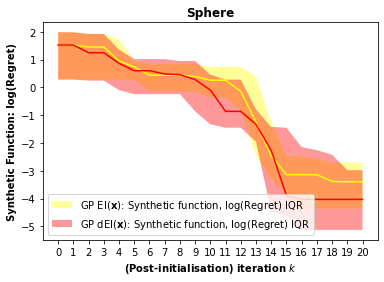

In [141]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


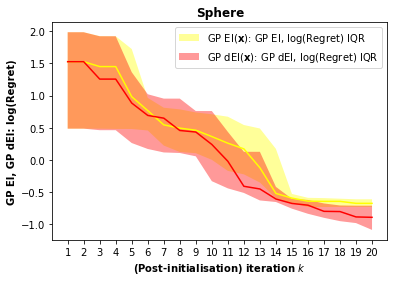

In [142]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx_acqFuncMin, color = 'Yellow')
plt.plot(median_exact_acqFuncMin, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approx_acqFuncMin, upper_approx_acqFuncMin, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): GP EI, log(Regret) IQR')
plt.fill_between(xstar, lower_exact_acqFuncMin, upper_exact_acqFuncMin, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): GP dEI, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()
